<a href="https://colab.research.google.com/github/shadiakiki1986/ml-competitions/blob/master/other/201902-gym-wtp/WtpOperatorEnv_v0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# WTP operator

This notebook demonstrates an openai/gym environment to simulate the operation of a water treatment plant.

It also trains a feed-forward neural network on this task under different starting conditions, and given random system failures. The agent learns to 
- start/stop the feed pump to transfer water from the raw water tank to the product water tank without overflow nor overdraw.
-  bypass a blocked element

# install pre-reqs

In [1]:
# install openai gym
!pip install gym | tail
!pip show gym

Name: gym
Version: 0.10.11
Summary: The OpenAI Gym: A toolkit for developing and comparing your reinforcement learning agents.
Home-page: https://github.com/openai/gym
Author: OpenAI
Author-email: gym@openai.com
License: UNKNOWN
Location: /usr/local/lib/python3.6/dist-packages
Requires: scipy, numpy, requests, six, pyglet
Required-by: tensor2tensor, stable-baselines, dopamine-rl


In [7]:
# install dependencies of rlworkgroup/garage
# Copied from colab/2019-01-21/t3.ipynb
#------------------------------------

# Install dependencies (copied from garage/environment.yml)
!apt-get install libglfw3 libglfw3-dev | tail

# >>>>>>>>   requires restart of runtime in colab.research.google.com due to joblib and rsa <<<<<<
!pip install awscli  boto3  cached_property  cloudpickle  cma==1.1.06 flask  gym  "box2d-py>=2.3.4"  hyperopt  ipdb  ipywidgets  jsonmerge  "joblib<0.13,>=0.12"  jupyter  mako  matplotlib  memory_profiler  pandas  path.py    polling  pre_commit  protobuf  psutil  pygame  pyglet  PyOpenGL  pyprind  python-dateutil  pyzmq  scikit-image  scipy  tensorboard  | tail
#"tensorflow<1.10,>=1.9.0"  Theano==1.0.2    "mujoco-py<1.50.2,>=1.50.1" gym[all]==0.10.8
#!pip install jsonmerge glfw mako pygame
!pip install pyprind cma glfw | tail

# Install garage (continued in next cell)
!git clone https://github.com/rlworkgroup/garage
# !cd garage && pip install -e . # >>>>>>>>   requires restart of runtime in colab.research.google.com due to joblib and rsa <<<<<<
#!pip show rlgarage garage

Reading package lists...
Building dependency tree...
Reading state information...
libglfw3 is already the newest version (3.2.1-1).
libglfw3-dev is already the newest version (3.2.1-1).
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.
Cloning into 'garage'...
remote: Enumerating objects: 116, done.
remote: Counting objects: 100% (116/116), done.
remote: Compressing objects: 100% (81/81), done.
remote: Total 10472 (delta 54), reused 60 (delta 35), pack-reused 10356
Receiving objects: 100% (10472/10472), 9.13 MiB | 10.29 MiB/s, done.
Resolving deltas: 100% (7322/7322), done.


In [9]:
# Install garage, commit e7324a68dedd94b4ea15a9c761bab2af032e2480 before the upcoming commits related to bumping gym/dm-control/mujoco versions
!cd garage && git checkout e7324a68dedd94b4ea15a9c761bab2af032e2480
!cd garage && pip install -e . # >>>>>>>>   requires restart of runtime in colab.research.google.com due to joblib and rsa <<<<<<

Note: checking out 'e7324a68dedd94b4ea15a9c761bab2af032e2480'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at e7324a6 Move nb_utils.py to garage.experiment
Obtaining file:///content/garage
  Running setup.py develop for rlgarage




---



---



---



# Utility functions

In [0]:
import pandas as pd

In [0]:
# utility
state_keys = [
    "wl_in", # wl: water level
    "pd1", # pd: pressure difference
    "pd2", 
    "wl_out"
]

action_keys = ["pump", "bp1", "bp2"]


def s_tp1_d2l(s_tp1):
    # convert state_tp1 from dict back to list
    #print("s in:", s_tp1)
    s_tp1 = [s_tp1[k] for k in state_keys]
    return s_tp1


def act_on_wtp(state_t, action_t):
  """
  Parameters
  state_t - state values, dict with keys being in `state_keys`
  action_t - action values, dict with keys being in `action_keys`
  
  Returns
  state_tp1 - state at t+1 after action
  reward - reward after action
  """
  debug=False
  
  #print("state/act(t)", state_t, action_t)
  
  # convert list to dict
  # state_t = dict(zip(state_keys, state_t))
  
  #print("----------")
  #print(state_t)
  #print("action_t", action_t)
  
  # any action taken
  any_action = any(action_t[x] for x in action_t)
  if not any_action:
    if debug: print("not doing anything and system is off")
    return state_t, 0

  # initialize
  state_tp1 = state_t.copy()
  reward = 0
  pump_capacity = 10 # pump capacity per time step
  
  # first, apply cost reward for energy to take action
  #action_t = dict(zip(action_keys, action_t))
  if action_t["pump"]:
    if debug: print("small punishment for electric power consumption")
    reward -= 1

  # continue applying actions to other elements
  if action_t["bp1"]:
    if debug: print("small punishment for electric power consumption")
    reward -= 1
    
  if action_t["bp2"]:
    if debug: print("small punishment for electric power consumption")
    reward -= 1

  if not action_t["pump"]:
    if debug: print("system is still off")
    return state_tp1, reward

  # when pump is in action
  if (
      # no blockage
      (state_t["pd1"] < 50) & (state_t["pd2"] < 50)
     ) | (
      # blockage present, but correct bypass is on
      (
          not ( (state_t["pd1"] >= 50) ^ action_t["bp1"] ) # not a xor b
      ) & (
          not ( (state_t["pd2"] >= 50) ^ action_t["bp2"] )
      )
     ):
    if debug: print("pump is on and water is flowing")
    if state_t["wl_in"] >= pump_capacity:
      if debug: print("positive reward for moving water")
      state_tp1["wl_out"] += pump_capacity
      state_tp1["wl_in"] -= pump_capacity
      reward += 7
    else:
      if debug: print("pump will overdraw from raw water tank")
      state_tp1["wl_out"] += state_t["wl_in"]
      state_tp1["wl_in"] = 0
      reward -= 20 # pump burning due to no water
          
  if state_tp1["wl_out"] > 100:
    if debug: print("punish for product tank overflowing")
    state_tp1["wl_out"] = 100
    reward -= 20
    
  if action_t["bp1"]:
    if debug: print("punish for lower water quality .. element 1")
    reward -= 1

  if action_t["bp2"]:
    if debug: print("punish for lower water quality .. element 2")
    reward -= 1

  if (state_t['wl_out']<100) & (state_tp1['wl_out']==100):
    if debug: print("bonus points for first attainment of full product tank")
    reward += 10
    
  # done
  return state_tp1, reward



In [0]:
# test reward for turning on bp1 while pump is on
s_t = {
    "wl_in": 100, # wl: water level
    "pd1": 100, # pd: pressure difference
    "pd2": 0, 
    "wl_out": 0
}

a_t = {"pump": True, 
       "bp1": True, 
       "bp2": False
      }


s_tp1, reward = act_on_wtp(s_t, a_t)
#print(s_tp1, reward)
assert reward > 0

In [0]:
# test reward for turning on bp1 while pump is on
s_t = {
    "wl_in": 100, # wl: water level
    "pd1": 100, # pd: pressure difference
    "pd2": 100, 
    "wl_out": 0
}

a_t = {"pump": True, 
       "bp1": True, 
       "bp2": True
      }


s_tp1, reward = act_on_wtp(s_t, a_t)
#print(s_tp1, reward)
assert reward > 0

In [0]:
# test issue of pump on, no differential pressure, and still water doesn't flow
s_t = {
    "wl_in": 70, # wl: water level
    "pd1": 0, # pd: pressure difference
    "pd2": 0, 
    "wl_out": 50
}

a_t = {"pump": 1, 
       "bp1": 0, 
       "bp2": 0
      }


s_tp1, reward = act_on_wtp(s_t, a_t)
#print(s_tp1, reward)
assert s_tp1['wl_in'] < s_t['wl_in']

In [0]:
# test issue of pump on, both dp blocked, only 1 bp on, and still water flows
s_t = {
    "wl_in": 70, # wl: water level
    "pd1": 100, # pd: pressure difference
    "pd2": 100, 
    "wl_out": 50
}

a_t = {"pump": 1, 
       "bp1": 1, 
       "bp2": 0
      }


s_tp1, reward = act_on_wtp(s_t, a_t)
#print(s_tp1, reward)
assert s_tp1['wl_in'] == s_t['wl_in']

In [7]:
# test on grid
df1 = []
for s_wl_in in [0,100]:
    for s_pd1 in [0, 100]:
        for s_pd2 in [0, 100]:
            for s_wl_out in [0,100]:
              for a_pump in [True,False]:
                for a_bp1 in [True,False]:
                  for a_bp2 in [True,False]:
                    s_t1 = [s_wl_in, s_pd1, s_pd2, s_wl_out]
                    a_t1 = [a_pump, a_bp1, a_bp2]
                    s_t2 = dict(zip(state_keys, s_t1))
                    a_t2 = dict(zip(action_keys, a_t1))
                    s_tp1a, reward = act_on_wtp(s_t2, a_t2)
                    s_tp1b = s_tp1_d2l(s_tp1a)
                    
                    row = []
                    row += s_t1
                    row += a_t1
                    row += s_tp1b
                    row += [reward]
                    
                    df1.append(row)
                    
print("done", len(df1))


done 128


In [8]:

colnames = [x+"_t" for x in state_keys] + action_keys + [x+"_tp1" for x in state_keys] + ["reward"]
df2 = pd.DataFrame(df1, columns = colnames)
df2 = df2.sort_values(['reward', 'wl_in_tp1', 'wl_out_tp1'], ascending=True).reset_index(drop=True)
#df2['wl_in_tp1'] = df2['wl_in_tp1'].astype('int64')
#df2['wl_out_tp1'] = df2['wl_out_tp1'].astype('int64')

df2.head()

,wl_in_t,pd1_t,pd2_t,wl_out_t,pump,bp1,bp2,wl_in_tp1,pd1_tp1,pd2_tp1,wl_out_tp1,reward
0,0,0,0,0,True,True,True,0,0,0,0,-25
1,0,100,100,0,True,True,True,0,100,100,0,-25
2,0,0,0,100,True,True,True,0,0,0,100,-25
3,0,100,100,100,True,True,True,0,100,100,100,-25
4,0,0,0,0,True,True,False,0,0,0,0,-23


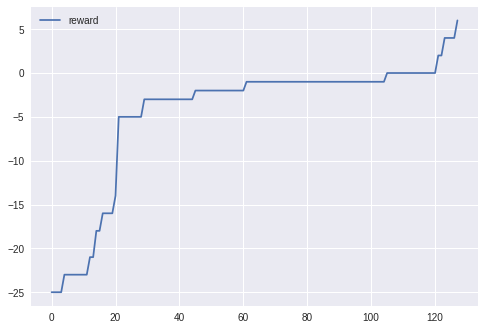

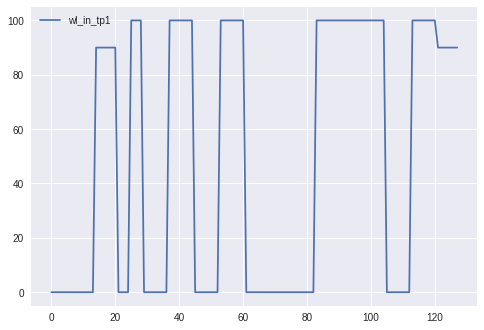

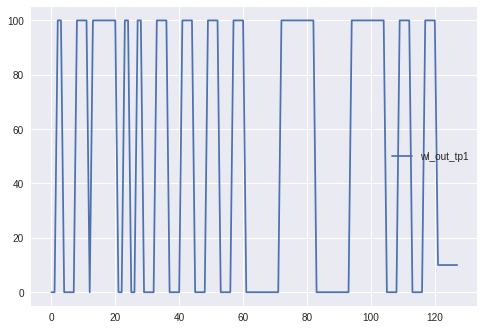

In [9]:
from matplotlib import pyplot as plt
df2[['reward']].plot()
plt.show()

df2[['wl_in_tp1']].plot()
plt.show()

df2[['wl_out_tp1']].plot()
plt.show()


# Create gym env

In [0]:
# Create a gym env that simulates the current water treatment plant
# Based on https://github.com/openai/gym/blob/master/gym/envs/toy_text/nchain.py

import gym
from gym import spaces
#from gym.utils import seeding
import numpy as np
import random



In [0]:

# Gym env
class WtpOperatorEnv_v0(gym.Env):
    """Water Treatment Plant / Operator environment
    
    This is a simulation of operating a water treatment plant (WTP).
    
    Observation:
      Parameters in water
      Type: Box(.)
      Water level in .. Range [0, 100]
      Pressure difference on element 1 .. Range [0,10]
      Pressure difference on element 2 .. Range [0,10]
      Water level out .. Range [0, 100]
      
    Actions:
      On/Off commands to pump, by-pass #1, by-pass #2
      Type: Dict of 3x Discrete(3)
      0 Do nothing
      1 flip state from off to on or on to off
      
    Reward: check function "act_on_wtp"
      
    Episode termination:
      Water level out is high at earliest time with minimal by-passing
    """
    def __init__(self):
        # number of steps to complete a WTP operation
        # FIXME 10 is probably too low for the agent to learn using the bypass
        # Increasing to 30
        self.n_steps = 20 # 30 # 10
        
        # probability that the differential pressure increases due to blockage
        # note that there is another 50% chance below that the blockage increases
        # FIXME 10% (i.e. 0.1) is not high enough for training to learn it in 200 iterations
        # Using 50% instead
        self.prob_block = {
            'pd1': 0.5, # 0.1 
            'pd2': 0.5, # 0.5, # FIXME disabling the blockage of the 2nd element in case this is hindering learning the usage of the bypass
        }
        
        #  actions: 0 for do nothing, 1 for flip state from off to on or vice versa
        self.action_space = spaces.Tuple([
            spaces.Discrete(2), # status of pump
            spaces.Discrete(2), # status of by-pass #1
            spaces.Discrete(2), # status of by-pass #2
        ])
        
        # observations: water levels, pressure differences
        obs_ranges = [
            [0, 100], # water level in
            [0, 100], # pressure difference #1
            [0, 100], # pressure difference #2
            [0, 100], # water level out
        ]
        self.observation_space = spaces.Box(
            low=np.array([x[0] for x in obs_ranges]),
            high=np.array([x[1] for x in obs_ranges]),
            dtype=np.float32
        )
        
        self.reset()
        #self.seed()

    #def seed(self, seed=None):
    #    self.np_random, seed = seeding.np_random(seed)
    #    return [seed]
    
    def reset(self, s0=None):
      # s0 - desired state
      if s0 is None:
        # sensors and equipment status on/off
        s0 = {
          "wl_in":  100, # input tank is full
          "pd1": 0, # differential pressure is negligible
          "pd2": 0, # differential pressure is negligible
          "wl_out":  20, # product tank is almost empty
        }
        
      self.state = s0.copy()
      self.step_i = 0
      
      # environment is fully observable, but state space needs to be converted from dict to list
      obs = s_tp1_d2l(self.state)
      return obs
    
    def step(self, act1):
        assert self.action_space.contains(act1), "action not in action space!"
        assert self.step_i < self.n_steps
        
        # increment number of steps taken
        self.step_i += 1

        # calculate reward of this action
        act2 = dict(zip(action_keys, act1)) # tuple to dict
        self.state, reward = act_on_wtp(self.state, act2)
        #print("\t state + element -> state after + reward", wtp_i, self.state, reward_i)
                                      
        # operate the WTP for n_steps
        done = self.step_i >= self.n_steps

        # decide on next-state block or not
        for dp_i in ['pd1', 'pd2']:
          blocked_1 = False
          if self.state[dp_i] == 0:
            # 10% chance of being blocked if not blocked already
            blocked_1 = (np.random.rand() < self.prob_block[dp_i]) # percentage that 1st element gets blockage
          else:
            # already blocked => continue being blocked
            blocked_1 = True

          if blocked_1:
            # 2019-02-14
            ## 50% chance of incrementing by 30 .. note that the blockage is digital at threshold 50
            #dp_increment_1 = (np.random.rand() > 0.5) * 30          
            #self.state[dp_i] += dp_increment_1
            #self.state[dp_i] = min(100, self.state[dp_i]) # cap at 100
            
            # 2019-02-15 just block straight away
            self.state[dp_i] = 100

        # environment is fully observable, but state space needs to be converted from dict to list
        obs_i = s_tp1_d2l(self.state)
        return obs_i, reward, done, {}


In [14]:
# itertools for generating grid search space
import itertools

# all possible actions
act_all = list(itertools.product(range(len([0,1,])), repeat=3)) # env_test.n_steps))
act_all = [list(x) for x in act_all]

# all possible 5-step sequences of actions
# Note that 10-step sequences would yield a set in the millions
# so it's not feasible to perform a grid search
act_all = list(itertools.product(act_all, repeat=5)) # env_test.n_steps))
act_all = [list(x) for x in act_all]

# appending 0's to the last 5 actions in the sequences
act_all = [x+[[0,0,0]]*5 for x in act_all]

# show sample
len(act_all), act_all[:2]

(32768,
 [[[0, 0, 0],
   [0, 0, 0],
   [0, 0, 0],
   [0, 0, 0],
   [0, 0, 0],
   [0, 0, 0],
   [0, 0, 0],
   [0, 0, 0],
   [0, 0, 0],
   [0, 0, 0]],
  [[0, 0, 0],
   [0, 0, 0],
   [0, 0, 0],
   [0, 0, 0],
   [0, 0, 1],
   [0, 0, 0],
   [0, 0, 0],
   [0, 0, 0],
   [0, 0, 0],
   [0, 0, 0]]])

In [15]:

# iterate
print("grid search .. start")
env_test = WtpOperatorEnv_v0()
obs_initial = env_test.reset().copy()
obs_initial = dict(zip(state_keys, obs_initial))

solution = dict(act_t=None, rew=-99999, obs_t=None)
done = False

n_all = len(act_all)
for i1, act_i1 in enumerate(act_all):
  if i1%1000 == 0: print(i1, n_all)
  reward_sum = 0
  env_test.reset(s0=obs_initial)
  obs_i1 = []
  # go through time steps and apply sequence of actions
  for t, act_i2 in enumerate(act_i1):
    #print("action", act_i2)
    obs_t, reward_i, done, _ = env_test.step(act_i2)
    obs_i1.append(obs_t)
    reward_sum += reward_i
    if done: break
    
  #print("water in", env_test.state, "wtp", [env_test.wtp_elements[x] for x in wtp_i], "water out", water_out, "reward", reward_sum)
  if reward_sum > solution['rew']:
    solution['act_t'] = act_i1 # sequence of actions
    solution['rew'] = reward_sum
    solution['obs_t'] = obs_i1 # trajectory


print("grid search .. end")


grid search .. start
0 32768
1000 32768
2000 32768
3000 32768
4000 32768
5000 32768
6000 32768
7000 32768
8000 32768
9000 32768
10000 32768
11000 32768
12000 32768
13000 32768
14000 32768
15000 32768
16000 32768
17000 32768
18000 32768
19000 32768
20000 32768
21000 32768
22000 32768
23000 32768
24000 32768
25000 32768
26000 32768
27000 32768
28000 32768
29000 32768
30000 32768
31000 32768
32000 32768
grid search .. end


In [16]:

# show result of grid search
print("*"*30)
print("initial observation", obs_initial)
print("action sequence chosen")
print(
  pd.concat(
    [ pd.DataFrame([dict(zip(action_keys, x)) for x in solution['act_t']]),
      pd.DataFrame([dict(zip(state_keys, x)) for x in solution['obs_t']]),
    ],
    axis=1
  )
)
print("final observation:", dict(zip(state_keys, solution['obs_t'])))
print("total reward", solution['rew'])

******************************
initial observation {'wl_in': 100, 'pd1': 0, 'pd2': 0, 'wl_out': 20}
action sequence chosen
   bp1  bp2  pump  pd1  pd2  wl_in  wl_out
0    0    0     1    0    0     90      30
1    0    0     1  100    0     80      40
2    1    0     1  100    0     70      50
3    1    0     1  100    0     60      60
4    1    0     1  100  100     50      70
5    0    0     0  100  100     50      70
6    0    0     0  100  100     50      70
7    0    0     0  100  100     50      70
8    0    0     0  100  100     50      70
9    0    0     0  100  100     50      70
final observation: {'wl_in': [90, 0, 0, 30], 'pd1': [80, 100, 0, 40], 'pd2': [70, 100, 0, 50], 'wl_out': [60, 100, 0, 60]}
total reward 24


# Register and train

In [0]:
# register the env with gym
# https://github.com/openai/gym/tree/master/gym/envs#how-to-create-new-environments-for-gym
from gym.envs.registration import register

register(
    id='WtpOperatorEnv-v0',
    #entry_point='gym_foo.envs:FooEnv',
    entry_point=WtpOperatorEnv_v0,
)

# test registration was successful
env = gym.make("WtpOperatorEnv-v0")

In [0]:
# The contents of this cell are mostly copied from garage/examples/...
# NEED TO run this twice for the first run in the runtime in colab, 1st for creating the personal config

from garage.baselines import LinearFeatureBaseline # <<<<<< requires restarting the runtime in colab after the 1st dependency installation above
from garage.envs import normalize
#from garage.envs.box2d import CartpoleEnv # no need since will use WtpDesignerEnv_v0 defined above
# from garage.experiment import run_experiment

from garage.tf.algos import TRPO
#from garage.tf.algos import PPO

from garage.tf.envs import TfEnv
#from garage.tf.policies import GaussianMLPPolicy
from garage.tf.policies import CategoricalMLPPolicy

import gym # already imported before

In [19]:
# FOR CPU OR GPU, use this, otherwise for TPU use the below
# ---------------------------------------------------------
# start a tensorflow session so that we can keep it open after training and use the trained network to see it performing
import tensorflow as tf
sess = tf.InteractiveSession()

# no need to initialize
#sess.run(tf.global_variables_initializer())


# check that we're indeed using GPU
# https://stackoverflow.com/a/38019608/4126114
#import tensorflow as tf
#sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
sess.list_devices()

[_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456, 12555414141301897951),
 _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 2647073469723689895),
 _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_GPU:0, XLA_GPU, 17179869184, 1297170415206749781),
 _DeviceAttributes(/job:localhost/replica:0/task:0/device:GPU:0, GPU, 11276946637, 10194978423308049224)]

In [0]:
def singlebase_to_multibase(y, dims):
  """
  Illustration
  
  >>> import itertools
  >>> x=np.array(list(itertools.product(range(4), range(3), range(2))))
  >>> y=x[:,0]*2*3 + x[:,1]*2 + x[:,2]
  >>> y.sort()
  >>> y
  array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
         17, 18, 19, 20, 21, 22, 23])

  Notice how "y" has no duplicates, and hence is a one-to-one mapping from the original matrix "x"

  Now convert y back to x

  >>> z1  = y//(2*3)
  >>> z1b = y %(2*3)
  >>> z2 = z1b//2
  >>> z2b = z1b %2
  >>> z3 = z2b//1
  >>> z = np.array([np.array(z1), np.array(z2), np.array(z3)]).T

  Notice that z == x
  
  
  Example:
  
  >>> import itertools
  >>> x = np.array(list(itertools.product(range(4), range(3), range(2))))
  >>> y = x[:,0]*2*3 + x[:,1]*2 + x[:,2]
  >>> z = singlebase_to_multibase(y, [4,3,2])
  >>> assert z == x
  """
  # calculate weights
  weights = dims[::-1] # reverse
  weights = np.array(weights).cumprod() # cumulative product
  weights = np.roll(weights, 1) # move last entry to first
  weights[0] = 1 # overwrite
  weights = weights[::-1] # reverse  
  # calcalate output
  z0 = []
  z_b = y
  for w in weights:
    z_  = z_b // w
    z0.append(z_)
    z_b = z_b % w
  # return
  z0 = np.array(z0).T
  return z0

###########
# test
import itertools
x = np.array(list(itertools.product(range(4), range(3), range(2))))
y = x[:,0]*2*3 + x[:,1]*2 + x[:,2]
z = singlebase_to_multibase(y, [4,3,2])
assert (z==x).all()

In [0]:
class UnFlattenActTupleWrapper(gym.ActionWrapper):
    """
    UnFlattens a Discrete action into a Tuple action space
    
    Inherits from ActionWrapper
    https://github.com/openai/gym/blob/6497c9f1c6e43066c8945f02ed3ed4d234f45dc1/gym/core.py
    """
    def __init__(self, env):
        super().__init__(env)

        # save action_space dimensions once
        self.dims = [c.n for c in env.action_space.spaces]
        flat_dim = np.array(self.dims).prod()
        self.action_space = spaces.Discrete(flat_dim)

        
    def action(self, action_in):
      return self.convert_action(action_in)
      
    def convert_action(self, action_in):
        """
        convert a flat action into tuple
        
        based on t0-0e FlattenDictWrapper2
        """
        action_out = singlebase_to_multibase(action_in, self.dims)
        action_out = np.array(action_out).astype('int')
        action_out = tuple(action_out)
        return action_out


In [22]:
# Train the policy (neural network) on the environment
#----------------------------------
from gym import wrappers

# env = TfEnv(normalize(gym.make("CartPole-v0")))
env = gym.make("WtpOperatorEnv-v0")
env = UnFlattenActTupleWrapper(env)
env = TfEnv(normalize(env))

# Using larger hidden sizes to learn to use the bypass
hidden_sizes=(32, 32)
#hidden_sizes=(64, 64)

policy = CategoricalMLPPolicy(name="policy", env_spec=env.spec, hidden_sizes=hidden_sizes)

baseline = LinearFeatureBaseline(env_spec=env.spec)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.random.categorical instead.


In [23]:

algo = TRPO(
#algo = PPO(
    env=env,
    policy=policy,
    baseline=baseline,
    batch_size=4000,
    max_path_length=env.env.env.env.n_steps+2, # add 2 since this is just a safety measure
    #n_itr=5, # smoke test
    n_itr=100,
    discount=0.99,
    max_kl_step=0.01,
    plot=False)


Instructions for updating:
Use tf.cast instead.


In [24]:

algo.train(sess=sess)

2019-02-16 20:33:43 | itr #0 | Obtaining samples...
2019-02-16 20:33:43 | itr #0 | Obtaining samples for iteration 0...


0% [##############################] 100% | ETA: 00:00:00

2019-02-16 20:33:44 | itr #0 | Processing samples...



Total time elapsed: 00:00:01


2019-02-16 20:33:44 | itr #0 | Logging diagnostics...
2019-02-16 20:33:44 | itr #0 | Optimizing policy...
2019-02-16 20:33:44 | itr #0 | Computing loss before
2019-02-16 20:33:46 | itr #0 | Computing KL before
2019-02-16 20:33:46 | itr #0 | Optimizing
2019-02-16 20:33:46 | itr #0 | Start CG optimization: #parameters: 1480, #inputs: 200, #subsample_inputs: 200
2019-02-16 20:33:46 | itr #0 | computing loss before
2019-02-16 20:33:46 | itr #0 | performing update
2019-02-16 20:33:46 | itr #0 | computing gradient
2019-02-16 20:33:46 | itr #0 | gradient computed
2019-02-16 20:33:46 | itr #0 | computing descent direction
2019-02-16 20:33:47 | itr #0 | descent direction computed
2019-02-16 20:33:47 | itr #0 | backtrack iters: 1
2019-02-16 20:33:47 | itr #0 | computing loss after
2019-02-16 20:33:47 | itr #0 | optimization finished
2019-02-16 20:33:47 | itr #0 | Computing KL after
2019-02-16 20:33:47 | itr #0 | Computing loss after
2019-02-16 20:33:47 | itr #0 | Fitting baseline...
2019-02-16 2

0% [##############################] 100% | ETA: 00:00:00

2019-02-16 20:33:48 | itr #1 | Processing samples...



Total time elapsed: 00:00:00


2019-02-16 20:33:48 | itr #1 | Logging diagnostics...
2019-02-16 20:33:48 | itr #1 | Optimizing policy...
2019-02-16 20:33:48 | itr #1 | Computing loss before
2019-02-16 20:33:48 | itr #1 | Computing KL before
2019-02-16 20:33:48 | itr #1 | Optimizing
2019-02-16 20:33:48 | itr #1 | Start CG optimization: #parameters: 1480, #inputs: 200, #subsample_inputs: 200
2019-02-16 20:33:48 | itr #1 | computing loss before
2019-02-16 20:33:48 | itr #1 | performing update
2019-02-16 20:33:48 | itr #1 | computing gradient
2019-02-16 20:33:48 | itr #1 | gradient computed
2019-02-16 20:33:48 | itr #1 | computing descent direction
2019-02-16 20:33:48 | itr #1 | descent direction computed
2019-02-16 20:33:48 | itr #1 | backtrack iters: 2
2019-02-16 20:33:48 | itr #1 | computing loss after
2019-02-16 20:33:48 | itr #1 | optimization finished
2019-02-16 20:33:48 | itr #1 | Computing KL after
2019-02-16 20:33:48 | itr #1 | Computing loss after
2019-02-16 20:33:48 | itr #1 | Fitting baseline...
2019-02-16 2

0% [##############################] 100% | ETA: 00:00:00

2019-02-16 20:33:49 | itr #2 | Processing samples...



Total time elapsed: 00:00:00


2019-02-16 20:33:49 | itr #2 | Logging diagnostics...
2019-02-16 20:33:49 | itr #2 | Optimizing policy...
2019-02-16 20:33:49 | itr #2 | Computing loss before
2019-02-16 20:33:49 | itr #2 | Computing KL before
2019-02-16 20:33:49 | itr #2 | Optimizing
2019-02-16 20:33:49 | itr #2 | Start CG optimization: #parameters: 1480, #inputs: 200, #subsample_inputs: 200
2019-02-16 20:33:49 | itr #2 | computing loss before
2019-02-16 20:33:49 | itr #2 | performing update
2019-02-16 20:33:49 | itr #2 | computing gradient
2019-02-16 20:33:49 | itr #2 | gradient computed
2019-02-16 20:33:49 | itr #2 | computing descent direction
2019-02-16 20:33:49 | itr #2 | descent direction computed
2019-02-16 20:33:49 | itr #2 | backtrack iters: 1
2019-02-16 20:33:49 | itr #2 | computing loss after
2019-02-16 20:33:49 | itr #2 | optimization finished
2019-02-16 20:33:49 | itr #2 | Computing KL after
2019-02-16 20:33:49 | itr #2 | Computing loss after
2019-02-16 20:33:49 | itr #2 | Fitting baseline...
2019-02-16 2

0% [##############################] 100% | ETA: 00:00:00

2019-02-16 20:33:50 | itr #3 | Processing samples...



Total time elapsed: 00:00:00


2019-02-16 20:33:50 | itr #3 | Logging diagnostics...
2019-02-16 20:33:50 | itr #3 | Optimizing policy...
2019-02-16 20:33:50 | itr #3 | Computing loss before
2019-02-16 20:33:50 | itr #3 | Computing KL before
2019-02-16 20:33:50 | itr #3 | Optimizing
2019-02-16 20:33:50 | itr #3 | Start CG optimization: #parameters: 1480, #inputs: 200, #subsample_inputs: 200
2019-02-16 20:33:50 | itr #3 | computing loss before
2019-02-16 20:33:50 | itr #3 | performing update
2019-02-16 20:33:50 | itr #3 | computing gradient
2019-02-16 20:33:50 | itr #3 | gradient computed
2019-02-16 20:33:50 | itr #3 | computing descent direction
2019-02-16 20:33:50 | itr #3 | descent direction computed
2019-02-16 20:33:50 | itr #3 | backtrack iters: 0
2019-02-16 20:33:50 | itr #3 | computing loss after
2019-02-16 20:33:50 | itr #3 | optimization finished
2019-02-16 20:33:50 | itr #3 | Computing KL after
2019-02-16 20:33:50 | itr #3 | Computing loss after
2019-02-16 20:33:50 | itr #3 | Fitting baseline...
2019-02-16 2

0% [##############################] 100% | ETA: 00:00:00

2019-02-16 20:33:50 | itr #4 | Processing samples...



Total time elapsed: 00:00:00


2019-02-16 20:33:50 | itr #4 | Logging diagnostics...
2019-02-16 20:33:50 | itr #4 | Optimizing policy...
2019-02-16 20:33:50 | itr #4 | Computing loss before
2019-02-16 20:33:50 | itr #4 | Computing KL before
2019-02-16 20:33:51 | itr #4 | Optimizing
2019-02-16 20:33:51 | itr #4 | Start CG optimization: #parameters: 1480, #inputs: 200, #subsample_inputs: 200
2019-02-16 20:33:51 | itr #4 | computing loss before
2019-02-16 20:33:51 | itr #4 | performing update
2019-02-16 20:33:51 | itr #4 | computing gradient
2019-02-16 20:33:51 | itr #4 | gradient computed
2019-02-16 20:33:51 | itr #4 | computing descent direction
2019-02-16 20:33:51 | itr #4 | descent direction computed
2019-02-16 20:33:51 | itr #4 | backtrack iters: 0
2019-02-16 20:33:51 | itr #4 | computing loss after
2019-02-16 20:33:51 | itr #4 | optimization finished
2019-02-16 20:33:51 | itr #4 | Computing KL after
2019-02-16 20:33:51 | itr #4 | Computing loss after
2019-02-16 20:33:51 | itr #4 | Fitting baseline...
2019-02-16 2

0% [##############################] 100% | ETA: 00:00:00

2019-02-16 20:33:51 | itr #5 | Processing samples...



Total time elapsed: 00:00:00


2019-02-16 20:33:51 | itr #5 | Logging diagnostics...
2019-02-16 20:33:51 | itr #5 | Optimizing policy...
2019-02-16 20:33:51 | itr #5 | Computing loss before
2019-02-16 20:33:52 | itr #5 | Computing KL before
2019-02-16 20:33:52 | itr #5 | Optimizing
2019-02-16 20:33:52 | itr #5 | Start CG optimization: #parameters: 1480, #inputs: 200, #subsample_inputs: 200
2019-02-16 20:33:52 | itr #5 | computing loss before
2019-02-16 20:33:52 | itr #5 | performing update
2019-02-16 20:33:52 | itr #5 | computing gradient
2019-02-16 20:33:52 | itr #5 | gradient computed
2019-02-16 20:33:52 | itr #5 | computing descent direction
2019-02-16 20:33:52 | itr #5 | descent direction computed
2019-02-16 20:33:52 | itr #5 | backtrack iters: 0
2019-02-16 20:33:52 | itr #5 | computing loss after
2019-02-16 20:33:52 | itr #5 | optimization finished
2019-02-16 20:33:52 | itr #5 | Computing KL after
2019-02-16 20:33:52 | itr #5 | Computing loss after
2019-02-16 20:33:52 | itr #5 | Fitting baseline...
2019-02-16 2

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


2019-02-16 20:33:52 | itr #6 | Processing samples...
2019-02-16 20:33:52 | itr #6 | Logging diagnostics...
2019-02-16 20:33:52 | itr #6 | Optimizing policy...
2019-02-16 20:33:52 | itr #6 | Computing loss before
2019-02-16 20:33:52 | itr #6 | Computing KL before
2019-02-16 20:33:52 | itr #6 | Optimizing
2019-02-16 20:33:52 | itr #6 | Start CG optimization: #parameters: 1480, #inputs: 200, #subsample_inputs: 200
2019-02-16 20:33:52 | itr #6 | computing loss before
2019-02-16 20:33:52 | itr #6 | performing update
2019-02-16 20:33:52 | itr #6 | computing gradient
2019-02-16 20:33:53 | itr #6 | gradient computed
2019-02-16 20:33:53 | itr #6 | computing descent direction
2019-02-16 20:33:53 | itr #6 | descent direction computed
2019-02-16 20:33:53 | itr #6 | backtrack iters: 2
2019-02-16 20:33:53 | itr #6 | computing loss after
2019-02-16 20:33:53 | itr #6 | optimization finished
2019-02-16 20:33:53 | itr #6 | Computing KL after
2019-02-16 20:33:53 | itr #6 | Computing loss after
2019-02-16

0% [##############################] 100% | ETA: 00:00:00

2019-02-16 20:33:53 | itr #7 | Processing samples...



Total time elapsed: 00:00:00


2019-02-16 20:33:53 | itr #7 | Logging diagnostics...
2019-02-16 20:33:53 | itr #7 | Optimizing policy...
2019-02-16 20:33:53 | itr #7 | Computing loss before
2019-02-16 20:33:53 | itr #7 | Computing KL before
2019-02-16 20:33:53 | itr #7 | Optimizing
2019-02-16 20:33:53 | itr #7 | Start CG optimization: #parameters: 1480, #inputs: 200, #subsample_inputs: 200
2019-02-16 20:33:53 | itr #7 | computing loss before
2019-02-16 20:33:53 | itr #7 | performing update
2019-02-16 20:33:53 | itr #7 | computing gradient
2019-02-16 20:33:54 | itr #7 | gradient computed
2019-02-16 20:33:54 | itr #7 | computing descent direction
2019-02-16 20:33:54 | itr #7 | descent direction computed
2019-02-16 20:33:54 | itr #7 | backtrack iters: 0
2019-02-16 20:33:54 | itr #7 | computing loss after
2019-02-16 20:33:54 | itr #7 | optimization finished
2019-02-16 20:33:54 | itr #7 | Computing KL after
2019-02-16 20:33:54 | itr #7 | Computing loss after
2019-02-16 20:33:54 | itr #7 | Fitting baseline...
2019-02-16 2

0% [##############################] 100% | ETA: 00:00:00

2019-02-16 20:33:55 | itr #8 | Processing samples...



Total time elapsed: 00:00:00


2019-02-16 20:33:55 | itr #8 | Logging diagnostics...
2019-02-16 20:33:55 | itr #8 | Optimizing policy...
2019-02-16 20:33:55 | itr #8 | Computing loss before
2019-02-16 20:33:55 | itr #8 | Computing KL before
2019-02-16 20:33:55 | itr #8 | Optimizing
2019-02-16 20:33:55 | itr #8 | Start CG optimization: #parameters: 1480, #inputs: 200, #subsample_inputs: 200
2019-02-16 20:33:55 | itr #8 | computing loss before
2019-02-16 20:33:55 | itr #8 | performing update
2019-02-16 20:33:55 | itr #8 | computing gradient
2019-02-16 20:33:55 | itr #8 | gradient computed
2019-02-16 20:33:55 | itr #8 | computing descent direction
2019-02-16 20:33:55 | itr #8 | descent direction computed
2019-02-16 20:33:55 | itr #8 | backtrack iters: 1
2019-02-16 20:33:55 | itr #8 | computing loss after
2019-02-16 20:33:55 | itr #8 | optimization finished
2019-02-16 20:33:55 | itr #8 | Computing KL after
2019-02-16 20:33:55 | itr #8 | Computing loss after
2019-02-16 20:33:55 | itr #8 | Fitting baseline...
2019-02-16 2

0% [##############################] 100% | ETA: 00:00:00

2019-02-16 20:33:56 | itr #9 | Processing samples...



Total time elapsed: 00:00:00


2019-02-16 20:33:56 | itr #9 | Logging diagnostics...
2019-02-16 20:33:56 | itr #9 | Optimizing policy...
2019-02-16 20:33:56 | itr #9 | Computing loss before
2019-02-16 20:33:56 | itr #9 | Computing KL before
2019-02-16 20:33:56 | itr #9 | Optimizing
2019-02-16 20:33:56 | itr #9 | Start CG optimization: #parameters: 1480, #inputs: 200, #subsample_inputs: 200
2019-02-16 20:33:56 | itr #9 | computing loss before
2019-02-16 20:33:56 | itr #9 | performing update
2019-02-16 20:33:56 | itr #9 | computing gradient
2019-02-16 20:33:56 | itr #9 | gradient computed
2019-02-16 20:33:56 | itr #9 | computing descent direction
2019-02-16 20:33:56 | itr #9 | descent direction computed
2019-02-16 20:33:56 | itr #9 | backtrack iters: 0
2019-02-16 20:33:56 | itr #9 | computing loss after
2019-02-16 20:33:56 | itr #9 | optimization finished
2019-02-16 20:33:56 | itr #9 | Computing KL after
2019-02-16 20:33:56 | itr #9 | Computing loss after
2019-02-16 20:33:56 | itr #9 | Fitting baseline...
2019-02-16 2

0% [##############################] 100% | ETA: 00:00:00

2019-02-16 20:33:57 | itr #10 | Processing samples...



Total time elapsed: 00:00:00


2019-02-16 20:33:57 | itr #10 | Logging diagnostics...
2019-02-16 20:33:57 | itr #10 | Optimizing policy...
2019-02-16 20:33:57 | itr #10 | Computing loss before
2019-02-16 20:33:57 | itr #10 | Computing KL before
2019-02-16 20:33:57 | itr #10 | Optimizing
2019-02-16 20:33:57 | itr #10 | Start CG optimization: #parameters: 1480, #inputs: 200, #subsample_inputs: 200
2019-02-16 20:33:57 | itr #10 | computing loss before
2019-02-16 20:33:57 | itr #10 | performing update
2019-02-16 20:33:57 | itr #10 | computing gradient
2019-02-16 20:33:57 | itr #10 | gradient computed
2019-02-16 20:33:57 | itr #10 | computing descent direction
2019-02-16 20:33:57 | itr #10 | descent direction computed
2019-02-16 20:33:57 | itr #10 | backtrack iters: 3
2019-02-16 20:33:57 | itr #10 | computing loss after
2019-02-16 20:33:57 | itr #10 | optimization finished
2019-02-16 20:33:57 | itr #10 | Computing KL after
2019-02-16 20:33:57 | itr #10 | Computing loss after
2019-02-16 20:33:57 | itr #10 | Fitting baseli

0% [##############################] 100% | ETA: 00:00:00

2019-02-16 20:33:58 | itr #11 | Processing samples...



Total time elapsed: 00:00:00


2019-02-16 20:33:58 | itr #11 | Logging diagnostics...
2019-02-16 20:33:58 | itr #11 | Optimizing policy...
2019-02-16 20:33:58 | itr #11 | Computing loss before
2019-02-16 20:33:58 | itr #11 | Computing KL before
2019-02-16 20:33:58 | itr #11 | Optimizing
2019-02-16 20:33:58 | itr #11 | Start CG optimization: #parameters: 1480, #inputs: 200, #subsample_inputs: 200
2019-02-16 20:33:58 | itr #11 | computing loss before
2019-02-16 20:33:58 | itr #11 | performing update
2019-02-16 20:33:58 | itr #11 | computing gradient
2019-02-16 20:33:58 | itr #11 | gradient computed
2019-02-16 20:33:58 | itr #11 | computing descent direction
2019-02-16 20:33:58 | itr #11 | descent direction computed
2019-02-16 20:33:58 | itr #11 | backtrack iters: 3
2019-02-16 20:33:58 | itr #11 | computing loss after
2019-02-16 20:33:58 | itr #11 | optimization finished
2019-02-16 20:33:58 | itr #11 | Computing KL after
2019-02-16 20:33:58 | itr #11 | Computing loss after
2019-02-16 20:33:58 | itr #11 | Fitting baseli

0% [##############################] 100% | ETA: 00:00:00

2019-02-16 20:33:59 | itr #12 | Processing samples...



Total time elapsed: 00:00:00


2019-02-16 20:33:59 | itr #12 | Logging diagnostics...
2019-02-16 20:33:59 | itr #12 | Optimizing policy...
2019-02-16 20:33:59 | itr #12 | Computing loss before
2019-02-16 20:33:59 | itr #12 | Computing KL before
2019-02-16 20:33:59 | itr #12 | Optimizing
2019-02-16 20:33:59 | itr #12 | Start CG optimization: #parameters: 1480, #inputs: 200, #subsample_inputs: 200
2019-02-16 20:33:59 | itr #12 | computing loss before
2019-02-16 20:33:59 | itr #12 | performing update
2019-02-16 20:33:59 | itr #12 | computing gradient
2019-02-16 20:33:59 | itr #12 | gradient computed
2019-02-16 20:33:59 | itr #12 | computing descent direction
2019-02-16 20:33:59 | itr #12 | descent direction computed
2019-02-16 20:33:59 | itr #12 | backtrack iters: 4
2019-02-16 20:33:59 | itr #12 | computing loss after
2019-02-16 20:33:59 | itr #12 | optimization finished
2019-02-16 20:33:59 | itr #12 | Computing KL after
2019-02-16 20:33:59 | itr #12 | Computing loss after
2019-02-16 20:33:59 | itr #12 | Fitting baseli

0% [##############################] 100% | ETA: 00:00:00

2019-02-16 20:34:00 | itr #13 | Processing samples...



Total time elapsed: 00:00:00


2019-02-16 20:34:00 | itr #13 | Logging diagnostics...
2019-02-16 20:34:00 | itr #13 | Optimizing policy...
2019-02-16 20:34:00 | itr #13 | Computing loss before
2019-02-16 20:34:00 | itr #13 | Computing KL before
2019-02-16 20:34:00 | itr #13 | Optimizing
2019-02-16 20:34:00 | itr #13 | Start CG optimization: #parameters: 1480, #inputs: 200, #subsample_inputs: 200
2019-02-16 20:34:00 | itr #13 | computing loss before
2019-02-16 20:34:00 | itr #13 | performing update
2019-02-16 20:34:00 | itr #13 | computing gradient
2019-02-16 20:34:00 | itr #13 | gradient computed
2019-02-16 20:34:00 | itr #13 | computing descent direction
2019-02-16 20:34:00 | itr #13 | descent direction computed
2019-02-16 20:34:00 | itr #13 | backtrack iters: 0
2019-02-16 20:34:00 | itr #13 | computing loss after
2019-02-16 20:34:00 | itr #13 | optimization finished
2019-02-16 20:34:00 | itr #13 | Computing KL after
2019-02-16 20:34:00 | itr #13 | Computing loss after
2019-02-16 20:34:00 | itr #13 | Fitting baseli

0% [##############################] 100% | ETA: 00:00:00

2019-02-16 20:34:01 | itr #14 | Processing samples...



Total time elapsed: 00:00:00


2019-02-16 20:34:01 | itr #14 | Logging diagnostics...
2019-02-16 20:34:01 | itr #14 | Optimizing policy...
2019-02-16 20:34:01 | itr #14 | Computing loss before
2019-02-16 20:34:01 | itr #14 | Computing KL before
2019-02-16 20:34:01 | itr #14 | Optimizing
2019-02-16 20:34:01 | itr #14 | Start CG optimization: #parameters: 1480, #inputs: 200, #subsample_inputs: 200
2019-02-16 20:34:01 | itr #14 | computing loss before
2019-02-16 20:34:01 | itr #14 | performing update
2019-02-16 20:34:01 | itr #14 | computing gradient
2019-02-16 20:34:01 | itr #14 | gradient computed
2019-02-16 20:34:01 | itr #14 | computing descent direction
2019-02-16 20:34:01 | itr #14 | descent direction computed
2019-02-16 20:34:01 | itr #14 | backtrack iters: 1
2019-02-16 20:34:01 | itr #14 | computing loss after
2019-02-16 20:34:01 | itr #14 | optimization finished
2019-02-16 20:34:01 | itr #14 | Computing KL after
2019-02-16 20:34:01 | itr #14 | Computing loss after
2019-02-16 20:34:01 | itr #14 | Fitting baseli

0% [##############################] 100% | ETA: 00:00:00

2019-02-16 20:34:01 | itr #15 | Processing samples...



Total time elapsed: 00:00:00


2019-02-16 20:34:02 | itr #15 | Logging diagnostics...
2019-02-16 20:34:02 | itr #15 | Optimizing policy...
2019-02-16 20:34:02 | itr #15 | Computing loss before
2019-02-16 20:34:02 | itr #15 | Computing KL before
2019-02-16 20:34:02 | itr #15 | Optimizing
2019-02-16 20:34:02 | itr #15 | Start CG optimization: #parameters: 1480, #inputs: 200, #subsample_inputs: 200
2019-02-16 20:34:02 | itr #15 | computing loss before
2019-02-16 20:34:02 | itr #15 | performing update
2019-02-16 20:34:02 | itr #15 | computing gradient
2019-02-16 20:34:02 | itr #15 | gradient computed
2019-02-16 20:34:02 | itr #15 | computing descent direction
2019-02-16 20:34:02 | itr #15 | descent direction computed
2019-02-16 20:34:02 | itr #15 | backtrack iters: 7
2019-02-16 20:34:02 | itr #15 | computing loss after
2019-02-16 20:34:02 | itr #15 | optimization finished
2019-02-16 20:34:02 | itr #15 | Computing KL after
2019-02-16 20:34:02 | itr #15 | Computing loss after
2019-02-16 20:34:02 | itr #15 | Fitting baseli

0% [##############################] 100% | ETA: 00:00:00

2019-02-16 20:34:03 | itr #16 | Processing samples...



Total time elapsed: 00:00:00


2019-02-16 20:34:03 | itr #16 | Logging diagnostics...
2019-02-16 20:34:03 | itr #16 | Optimizing policy...
2019-02-16 20:34:03 | itr #16 | Computing loss before
2019-02-16 20:34:03 | itr #16 | Computing KL before
2019-02-16 20:34:03 | itr #16 | Optimizing
2019-02-16 20:34:03 | itr #16 | Start CG optimization: #parameters: 1480, #inputs: 200, #subsample_inputs: 200
2019-02-16 20:34:03 | itr #16 | computing loss before
2019-02-16 20:34:03 | itr #16 | performing update
2019-02-16 20:34:03 | itr #16 | computing gradient
2019-02-16 20:34:03 | itr #16 | gradient computed
2019-02-16 20:34:03 | itr #16 | computing descent direction
2019-02-16 20:34:03 | itr #16 | descent direction computed
2019-02-16 20:34:03 | itr #16 | backtrack iters: 0
2019-02-16 20:34:03 | itr #16 | computing loss after
2019-02-16 20:34:03 | itr #16 | optimization finished
2019-02-16 20:34:03 | itr #16 | Computing KL after
2019-02-16 20:34:03 | itr #16 | Computing loss after
2019-02-16 20:34:03 | itr #16 | Fitting baseli

0% [##############################] 100% | ETA: 00:00:00

2019-02-16 20:34:04 | itr #17 | Processing samples...



Total time elapsed: 00:00:00


2019-02-16 20:34:04 | itr #17 | Logging diagnostics...
2019-02-16 20:34:04 | itr #17 | Optimizing policy...
2019-02-16 20:34:04 | itr #17 | Computing loss before
2019-02-16 20:34:04 | itr #17 | Computing KL before
2019-02-16 20:34:04 | itr #17 | Optimizing
2019-02-16 20:34:04 | itr #17 | Start CG optimization: #parameters: 1480, #inputs: 200, #subsample_inputs: 200
2019-02-16 20:34:04 | itr #17 | computing loss before
2019-02-16 20:34:04 | itr #17 | performing update
2019-02-16 20:34:04 | itr #17 | computing gradient
2019-02-16 20:34:04 | itr #17 | gradient computed
2019-02-16 20:34:04 | itr #17 | computing descent direction
2019-02-16 20:34:04 | itr #17 | descent direction computed
2019-02-16 20:34:04 | itr #17 | backtrack iters: 6
2019-02-16 20:34:04 | itr #17 | computing loss after
2019-02-16 20:34:04 | itr #17 | optimization finished
2019-02-16 20:34:04 | itr #17 | Computing KL after
2019-02-16 20:34:04 | itr #17 | Computing loss after
2019-02-16 20:34:04 | itr #17 | Fitting baseli

0% [##############################] 100% | ETA: 00:00:00

2019-02-16 20:34:05 | itr #18 | Processing samples...



Total time elapsed: 00:00:00


2019-02-16 20:34:05 | itr #18 | Logging diagnostics...
2019-02-16 20:34:05 | itr #18 | Optimizing policy...
2019-02-16 20:34:05 | itr #18 | Computing loss before
2019-02-16 20:34:05 | itr #18 | Computing KL before
2019-02-16 20:34:05 | itr #18 | Optimizing
2019-02-16 20:34:05 | itr #18 | Start CG optimization: #parameters: 1480, #inputs: 200, #subsample_inputs: 200
2019-02-16 20:34:05 | itr #18 | computing loss before
2019-02-16 20:34:05 | itr #18 | performing update
2019-02-16 20:34:05 | itr #18 | computing gradient
2019-02-16 20:34:05 | itr #18 | gradient computed
2019-02-16 20:34:05 | itr #18 | computing descent direction
2019-02-16 20:34:05 | itr #18 | descent direction computed
2019-02-16 20:34:05 | itr #18 | backtrack iters: 11
2019-02-16 20:34:05 | itr #18 | computing loss after
2019-02-16 20:34:05 | itr #18 | optimization finished
2019-02-16 20:34:05 | itr #18 | Computing KL after
2019-02-16 20:34:05 | itr #18 | Computing loss after
2019-02-16 20:34:05 | itr #18 | Fitting basel

0% [##############################] 100% | ETA: 00:00:00

2019-02-16 20:34:06 | itr #19 | Processing samples...



Total time elapsed: 00:00:00


2019-02-16 20:34:06 | itr #19 | Logging diagnostics...
2019-02-16 20:34:06 | itr #19 | Optimizing policy...
2019-02-16 20:34:06 | itr #19 | Computing loss before
2019-02-16 20:34:06 | itr #19 | Computing KL before
2019-02-16 20:34:06 | itr #19 | Optimizing
2019-02-16 20:34:06 | itr #19 | Start CG optimization: #parameters: 1480, #inputs: 200, #subsample_inputs: 200
2019-02-16 20:34:06 | itr #19 | computing loss before
2019-02-16 20:34:06 | itr #19 | performing update
2019-02-16 20:34:06 | itr #19 | computing gradient
2019-02-16 20:34:06 | itr #19 | gradient computed
2019-02-16 20:34:06 | itr #19 | computing descent direction
2019-02-16 20:34:06 | itr #19 | descent direction computed
2019-02-16 20:34:06 | itr #19 | backtrack iters: 4
2019-02-16 20:34:06 | itr #19 | computing loss after
2019-02-16 20:34:06 | itr #19 | optimization finished
2019-02-16 20:34:06 | itr #19 | Computing KL after
2019-02-16 20:34:06 | itr #19 | Computing loss after
2019-02-16 20:34:06 | itr #19 | Fitting baseli

0% [##############################] 100% | ETA: 00:00:00

2019-02-16 20:34:07 | itr #20 | Processing samples...



Total time elapsed: 00:00:00


2019-02-16 20:34:07 | itr #20 | Logging diagnostics...
2019-02-16 20:34:07 | itr #20 | Optimizing policy...
2019-02-16 20:34:07 | itr #20 | Computing loss before
2019-02-16 20:34:07 | itr #20 | Computing KL before
2019-02-16 20:34:07 | itr #20 | Optimizing
2019-02-16 20:34:07 | itr #20 | Start CG optimization: #parameters: 1480, #inputs: 200, #subsample_inputs: 200
2019-02-16 20:34:07 | itr #20 | computing loss before
2019-02-16 20:34:07 | itr #20 | performing update
2019-02-16 20:34:07 | itr #20 | computing gradient
2019-02-16 20:34:07 | itr #20 | gradient computed
2019-02-16 20:34:07 | itr #20 | computing descent direction
2019-02-16 20:34:07 | itr #20 | descent direction computed
2019-02-16 20:34:07 | itr #20 | backtrack iters: 1
2019-02-16 20:34:07 | itr #20 | computing loss after
2019-02-16 20:34:07 | itr #20 | optimization finished
2019-02-16 20:34:07 | itr #20 | Computing KL after
2019-02-16 20:34:07 | itr #20 | Computing loss after
2019-02-16 20:34:07 | itr #20 | Fitting baseli

0% [##############################] 100% | ETA: 00:00:00

2019-02-16 20:34:08 | itr #21 | Processing samples...



Total time elapsed: 00:00:00


2019-02-16 20:34:08 | itr #21 | Logging diagnostics...
2019-02-16 20:34:08 | itr #21 | Optimizing policy...
2019-02-16 20:34:08 | itr #21 | Computing loss before
2019-02-16 20:34:08 | itr #21 | Computing KL before
2019-02-16 20:34:08 | itr #21 | Optimizing
2019-02-16 20:34:08 | itr #21 | Start CG optimization: #parameters: 1480, #inputs: 200, #subsample_inputs: 200
2019-02-16 20:34:08 | itr #21 | computing loss before
2019-02-16 20:34:08 | itr #21 | performing update
2019-02-16 20:34:08 | itr #21 | computing gradient
2019-02-16 20:34:08 | itr #21 | gradient computed
2019-02-16 20:34:08 | itr #21 | computing descent direction
2019-02-16 20:34:08 | itr #21 | descent direction computed
2019-02-16 20:34:08 | itr #21 | backtrack iters: 9
2019-02-16 20:34:08 | itr #21 | computing loss after
2019-02-16 20:34:08 | itr #21 | optimization finished
2019-02-16 20:34:08 | itr #21 | Computing KL after
2019-02-16 20:34:08 | itr #21 | Computing loss after
2019-02-16 20:34:08 | itr #21 | Fitting baseli

0% [##############################] 100% | ETA: 00:00:00

2019-02-16 20:34:09 | itr #22 | Processing samples...



Total time elapsed: 00:00:00


2019-02-16 20:34:09 | itr #22 | Logging diagnostics...
2019-02-16 20:34:09 | itr #22 | Optimizing policy...
2019-02-16 20:34:09 | itr #22 | Computing loss before
2019-02-16 20:34:09 | itr #22 | Computing KL before
2019-02-16 20:34:09 | itr #22 | Optimizing
2019-02-16 20:34:09 | itr #22 | Start CG optimization: #parameters: 1480, #inputs: 200, #subsample_inputs: 200
2019-02-16 20:34:09 | itr #22 | computing loss before
2019-02-16 20:34:09 | itr #22 | performing update
2019-02-16 20:34:09 | itr #22 | computing gradient
2019-02-16 20:34:09 | itr #22 | gradient computed
2019-02-16 20:34:09 | itr #22 | computing descent direction
2019-02-16 20:34:09 | itr #22 | descent direction computed
2019-02-16 20:34:09 | itr #22 | backtrack iters: 6
2019-02-16 20:34:09 | itr #22 | computing loss after
2019-02-16 20:34:09 | itr #22 | optimization finished
2019-02-16 20:34:09 | itr #22 | Computing KL after
2019-02-16 20:34:09 | itr #22 | Computing loss after
2019-02-16 20:34:09 | itr #22 | Fitting baseli

0% [##############################] 100% | ETA: 00:00:00

2019-02-16 20:34:10 | itr #23 | Processing samples...



Total time elapsed: 00:00:00


2019-02-16 20:34:10 | itr #23 | Logging diagnostics...
2019-02-16 20:34:10 | itr #23 | Optimizing policy...
2019-02-16 20:34:10 | itr #23 | Computing loss before
2019-02-16 20:34:10 | itr #23 | Computing KL before
2019-02-16 20:34:10 | itr #23 | Optimizing
2019-02-16 20:34:10 | itr #23 | Start CG optimization: #parameters: 1480, #inputs: 200, #subsample_inputs: 200
2019-02-16 20:34:10 | itr #23 | computing loss before
2019-02-16 20:34:10 | itr #23 | performing update
2019-02-16 20:34:10 | itr #23 | computing gradient
2019-02-16 20:34:10 | itr #23 | gradient computed
2019-02-16 20:34:10 | itr #23 | computing descent direction
2019-02-16 20:34:10 | itr #23 | descent direction computed
2019-02-16 20:34:10 | itr #23 | backtrack iters: 3
2019-02-16 20:34:10 | itr #23 | computing loss after
2019-02-16 20:34:10 | itr #23 | optimization finished
2019-02-16 20:34:10 | itr #23 | Computing KL after
2019-02-16 20:34:10 | itr #23 | Computing loss after
2019-02-16 20:34:10 | itr #23 | Fitting baseli

0% [##############################] 100% | ETA: 00:00:00

2019-02-16 20:34:11 | itr #24 | Processing samples...



Total time elapsed: 00:00:00


2019-02-16 20:34:11 | itr #24 | Logging diagnostics...
2019-02-16 20:34:11 | itr #24 | Optimizing policy...
2019-02-16 20:34:11 | itr #24 | Computing loss before
2019-02-16 20:34:11 | itr #24 | Computing KL before
2019-02-16 20:34:11 | itr #24 | Optimizing
2019-02-16 20:34:11 | itr #24 | Start CG optimization: #parameters: 1480, #inputs: 200, #subsample_inputs: 200
2019-02-16 20:34:11 | itr #24 | computing loss before
2019-02-16 20:34:11 | itr #24 | performing update
2019-02-16 20:34:11 | itr #24 | computing gradient
2019-02-16 20:34:11 | itr #24 | gradient computed
2019-02-16 20:34:11 | itr #24 | computing descent direction
2019-02-16 20:34:11 | itr #24 | descent direction computed
2019-02-16 20:34:11 | itr #24 | backtrack iters: 0
2019-02-16 20:34:11 | itr #24 | computing loss after
2019-02-16 20:34:11 | itr #24 | optimization finished
2019-02-16 20:34:11 | itr #24 | Computing KL after
2019-02-16 20:34:11 | itr #24 | Computing loss after
2019-02-16 20:34:11 | itr #24 | Fitting baseli

0% [##############################] 100% | ETA: 00:00:00

2019-02-16 20:34:12 | itr #25 | Processing samples...



Total time elapsed: 00:00:00


2019-02-16 20:34:12 | itr #25 | Logging diagnostics...
2019-02-16 20:34:12 | itr #25 | Optimizing policy...
2019-02-16 20:34:12 | itr #25 | Computing loss before
2019-02-16 20:34:12 | itr #25 | Computing KL before
2019-02-16 20:34:12 | itr #25 | Optimizing
2019-02-16 20:34:12 | itr #25 | Start CG optimization: #parameters: 1480, #inputs: 200, #subsample_inputs: 200
2019-02-16 20:34:12 | itr #25 | computing loss before
2019-02-16 20:34:12 | itr #25 | performing update
2019-02-16 20:34:12 | itr #25 | computing gradient
2019-02-16 20:34:12 | itr #25 | gradient computed
2019-02-16 20:34:12 | itr #25 | computing descent direction
2019-02-16 20:34:12 | itr #25 | descent direction computed
2019-02-16 20:34:12 | itr #25 | backtrack iters: 4
2019-02-16 20:34:12 | itr #25 | computing loss after
2019-02-16 20:34:12 | itr #25 | optimization finished
2019-02-16 20:34:12 | itr #25 | Computing KL after
2019-02-16 20:34:12 | itr #25 | Computing loss after
2019-02-16 20:34:12 | itr #25 | Fitting baseli

0% [##############################] 100% | ETA: 00:00:00

2019-02-16 20:34:13 | itr #26 | Processing samples...



Total time elapsed: 00:00:00


2019-02-16 20:34:13 | itr #26 | Logging diagnostics...
2019-02-16 20:34:13 | itr #26 | Optimizing policy...
2019-02-16 20:34:13 | itr #26 | Computing loss before
2019-02-16 20:34:13 | itr #26 | Computing KL before
2019-02-16 20:34:13 | itr #26 | Optimizing
2019-02-16 20:34:13 | itr #26 | Start CG optimization: #parameters: 1480, #inputs: 200, #subsample_inputs: 200
2019-02-16 20:34:13 | itr #26 | computing loss before
2019-02-16 20:34:13 | itr #26 | performing update
2019-02-16 20:34:13 | itr #26 | computing gradient
2019-02-16 20:34:13 | itr #26 | gradient computed
2019-02-16 20:34:13 | itr #26 | computing descent direction
2019-02-16 20:34:13 | itr #26 | descent direction computed
2019-02-16 20:34:13 | itr #26 | backtrack iters: 0
2019-02-16 20:34:13 | itr #26 | computing loss after
2019-02-16 20:34:13 | itr #26 | optimization finished
2019-02-16 20:34:13 | itr #26 | Computing KL after
2019-02-16 20:34:13 | itr #26 | Computing loss after
2019-02-16 20:34:13 | itr #26 | Fitting baseli

0% [##############################] 100% | ETA: 00:00:00

2019-02-16 20:34:14 | itr #27 | Processing samples...



Total time elapsed: 00:00:00


2019-02-16 20:34:14 | itr #27 | Logging diagnostics...
2019-02-16 20:34:14 | itr #27 | Optimizing policy...
2019-02-16 20:34:14 | itr #27 | Computing loss before
2019-02-16 20:34:14 | itr #27 | Computing KL before
2019-02-16 20:34:14 | itr #27 | Optimizing
2019-02-16 20:34:14 | itr #27 | Start CG optimization: #parameters: 1480, #inputs: 200, #subsample_inputs: 200
2019-02-16 20:34:14 | itr #27 | computing loss before
2019-02-16 20:34:14 | itr #27 | performing update
2019-02-16 20:34:14 | itr #27 | computing gradient
2019-02-16 20:34:14 | itr #27 | gradient computed
2019-02-16 20:34:14 | itr #27 | computing descent direction
2019-02-16 20:34:14 | itr #27 | descent direction computed
2019-02-16 20:34:14 | itr #27 | backtrack iters: 9
2019-02-16 20:34:14 | itr #27 | computing loss after
2019-02-16 20:34:14 | itr #27 | optimization finished
2019-02-16 20:34:14 | itr #27 | Computing KL after
2019-02-16 20:34:14 | itr #27 | Computing loss after
2019-02-16 20:34:14 | itr #27 | Fitting baseli

0% [##############################] 100% | ETA: 00:00:00

2019-02-16 20:34:15 | itr #28 | Processing samples...



Total time elapsed: 00:00:00


2019-02-16 20:34:15 | itr #28 | Logging diagnostics...
2019-02-16 20:34:15 | itr #28 | Optimizing policy...
2019-02-16 20:34:15 | itr #28 | Computing loss before
2019-02-16 20:34:15 | itr #28 | Computing KL before
2019-02-16 20:34:15 | itr #28 | Optimizing
2019-02-16 20:34:15 | itr #28 | Start CG optimization: #parameters: 1480, #inputs: 200, #subsample_inputs: 200
2019-02-16 20:34:15 | itr #28 | computing loss before
2019-02-16 20:34:15 | itr #28 | performing update
2019-02-16 20:34:15 | itr #28 | computing gradient
2019-02-16 20:34:15 | itr #28 | gradient computed
2019-02-16 20:34:15 | itr #28 | computing descent direction
2019-02-16 20:34:15 | itr #28 | descent direction computed
2019-02-16 20:34:15 | itr #28 | backtrack iters: 1
2019-02-16 20:34:15 | itr #28 | computing loss after
2019-02-16 20:34:15 | itr #28 | optimization finished
2019-02-16 20:34:15 | itr #28 | Computing KL after
2019-02-16 20:34:15 | itr #28 | Computing loss after
2019-02-16 20:34:15 | itr #28 | Fitting baseli

0% [##############################] 100% | ETA: 00:00:00

2019-02-16 20:34:16 | itr #29 | Processing samples...



Total time elapsed: 00:00:00


2019-02-16 20:34:16 | itr #29 | Logging diagnostics...
2019-02-16 20:34:16 | itr #29 | Optimizing policy...
2019-02-16 20:34:16 | itr #29 | Computing loss before
2019-02-16 20:34:16 | itr #29 | Computing KL before
2019-02-16 20:34:16 | itr #29 | Optimizing
2019-02-16 20:34:16 | itr #29 | Start CG optimization: #parameters: 1480, #inputs: 200, #subsample_inputs: 200
2019-02-16 20:34:16 | itr #29 | computing loss before
2019-02-16 20:34:16 | itr #29 | performing update
2019-02-16 20:34:16 | itr #29 | computing gradient
2019-02-16 20:34:16 | itr #29 | gradient computed
2019-02-16 20:34:16 | itr #29 | computing descent direction
2019-02-16 20:34:16 | itr #29 | descent direction computed
2019-02-16 20:34:16 | itr #29 | backtrack iters: 3
2019-02-16 20:34:16 | itr #29 | computing loss after
2019-02-16 20:34:16 | itr #29 | optimization finished
2019-02-16 20:34:16 | itr #29 | Computing KL after
2019-02-16 20:34:16 | itr #29 | Computing loss after
2019-02-16 20:34:16 | itr #29 | Fitting baseli

0% [##############################] 100% | ETA: 00:00:00

2019-02-16 20:34:17 | itr #30 | Processing samples...



Total time elapsed: 00:00:00


2019-02-16 20:34:17 | itr #30 | Logging diagnostics...
2019-02-16 20:34:17 | itr #30 | Optimizing policy...
2019-02-16 20:34:17 | itr #30 | Computing loss before
2019-02-16 20:34:17 | itr #30 | Computing KL before
2019-02-16 20:34:17 | itr #30 | Optimizing
2019-02-16 20:34:17 | itr #30 | Start CG optimization: #parameters: 1480, #inputs: 200, #subsample_inputs: 200
2019-02-16 20:34:17 | itr #30 | computing loss before
2019-02-16 20:34:17 | itr #30 | performing update
2019-02-16 20:34:17 | itr #30 | computing gradient
2019-02-16 20:34:17 | itr #30 | gradient computed
2019-02-16 20:34:17 | itr #30 | computing descent direction
2019-02-16 20:34:17 | itr #30 | descent direction computed
2019-02-16 20:34:17 | itr #30 | backtrack iters: 5
2019-02-16 20:34:17 | itr #30 | computing loss after
2019-02-16 20:34:17 | itr #30 | optimization finished
2019-02-16 20:34:17 | itr #30 | Computing KL after
2019-02-16 20:34:17 | itr #30 | Computing loss after
2019-02-16 20:34:17 | itr #30 | Fitting baseli

0% [##############################] 100% | ETA: 00:00:00

2019-02-16 20:34:18 | itr #31 | Processing samples...



Total time elapsed: 00:00:00


2019-02-16 20:34:18 | itr #31 | Logging diagnostics...
2019-02-16 20:34:18 | itr #31 | Optimizing policy...
2019-02-16 20:34:18 | itr #31 | Computing loss before
2019-02-16 20:34:18 | itr #31 | Computing KL before
2019-02-16 20:34:18 | itr #31 | Optimizing
2019-02-16 20:34:18 | itr #31 | Start CG optimization: #parameters: 1480, #inputs: 200, #subsample_inputs: 200
2019-02-16 20:34:18 | itr #31 | computing loss before
2019-02-16 20:34:18 | itr #31 | performing update
2019-02-16 20:34:18 | itr #31 | computing gradient
2019-02-16 20:34:18 | itr #31 | gradient computed
2019-02-16 20:34:18 | itr #31 | computing descent direction
2019-02-16 20:34:18 | itr #31 | descent direction computed
2019-02-16 20:34:18 | itr #31 | backtrack iters: 2
2019-02-16 20:34:18 | itr #31 | computing loss after
2019-02-16 20:34:18 | itr #31 | optimization finished
2019-02-16 20:34:18 | itr #31 | Computing KL after
2019-02-16 20:34:18 | itr #31 | Computing loss after
2019-02-16 20:34:18 | itr #31 | Fitting baseli

0% [##############################] 100% | ETA: 00:00:00

2019-02-16 20:34:19 | itr #32 | Processing samples...



Total time elapsed: 00:00:00


2019-02-16 20:34:19 | itr #32 | Logging diagnostics...
2019-02-16 20:34:19 | itr #32 | Optimizing policy...
2019-02-16 20:34:19 | itr #32 | Computing loss before
2019-02-16 20:34:19 | itr #32 | Computing KL before
2019-02-16 20:34:19 | itr #32 | Optimizing
2019-02-16 20:34:19 | itr #32 | Start CG optimization: #parameters: 1480, #inputs: 200, #subsample_inputs: 200
2019-02-16 20:34:19 | itr #32 | computing loss before
2019-02-16 20:34:19 | itr #32 | performing update
2019-02-16 20:34:19 | itr #32 | computing gradient
2019-02-16 20:34:19 | itr #32 | gradient computed
2019-02-16 20:34:19 | itr #32 | computing descent direction
2019-02-16 20:34:19 | itr #32 | descent direction computed
2019-02-16 20:34:19 | itr #32 | backtrack iters: 1
2019-02-16 20:34:19 | itr #32 | computing loss after
2019-02-16 20:34:19 | itr #32 | optimization finished
2019-02-16 20:34:19 | itr #32 | Computing KL after
2019-02-16 20:34:19 | itr #32 | Computing loss after
2019-02-16 20:34:19 | itr #32 | Fitting baseli

0% [##############################] 100% | ETA: 00:00:00

2019-02-16 20:34:20 | itr #33 | Processing samples...



Total time elapsed: 00:00:00


2019-02-16 20:34:20 | itr #33 | Logging diagnostics...
2019-02-16 20:34:20 | itr #33 | Optimizing policy...
2019-02-16 20:34:20 | itr #33 | Computing loss before
2019-02-16 20:34:20 | itr #33 | Computing KL before
2019-02-16 20:34:20 | itr #33 | Optimizing
2019-02-16 20:34:20 | itr #33 | Start CG optimization: #parameters: 1480, #inputs: 200, #subsample_inputs: 200
2019-02-16 20:34:20 | itr #33 | computing loss before
2019-02-16 20:34:20 | itr #33 | performing update
2019-02-16 20:34:20 | itr #33 | computing gradient
2019-02-16 20:34:20 | itr #33 | gradient computed
2019-02-16 20:34:20 | itr #33 | computing descent direction
2019-02-16 20:34:20 | itr #33 | descent direction computed
2019-02-16 20:34:20 | itr #33 | backtrack iters: 13
2019-02-16 20:34:20 | itr #33 | computing loss after
2019-02-16 20:34:20 | itr #33 | optimization finished
2019-02-16 20:34:20 | itr #33 | Computing KL after
2019-02-16 20:34:20 | itr #33 | Computing loss after
2019-02-16 20:34:20 | itr #33 | Fitting basel

0% [##############################] 100% | ETA: 00:00:00

2019-02-16 20:34:21 | itr #34 | Processing samples...



Total time elapsed: 00:00:00


2019-02-16 20:34:21 | itr #34 | Logging diagnostics...
2019-02-16 20:34:21 | itr #34 | Optimizing policy...
2019-02-16 20:34:21 | itr #34 | Computing loss before
2019-02-16 20:34:21 | itr #34 | Computing KL before
2019-02-16 20:34:21 | itr #34 | Optimizing
2019-02-16 20:34:21 | itr #34 | Start CG optimization: #parameters: 1480, #inputs: 200, #subsample_inputs: 200
2019-02-16 20:34:21 | itr #34 | computing loss before
2019-02-16 20:34:21 | itr #34 | performing update
2019-02-16 20:34:21 | itr #34 | computing gradient
2019-02-16 20:34:21 | itr #34 | gradient computed
2019-02-16 20:34:21 | itr #34 | computing descent direction
2019-02-16 20:34:21 | itr #34 | descent direction computed
2019-02-16 20:34:21 | itr #34 | backtrack iters: 1
2019-02-16 20:34:21 | itr #34 | computing loss after
2019-02-16 20:34:21 | itr #34 | optimization finished
2019-02-16 20:34:21 | itr #34 | Computing KL after
2019-02-16 20:34:21 | itr #34 | Computing loss after
2019-02-16 20:34:21 | itr #34 | Fitting baseli

0% [##############################] 100% | ETA: 00:00:00

2019-02-16 20:34:22 | itr #35 | Processing samples...



Total time elapsed: 00:00:00


2019-02-16 20:34:22 | itr #35 | Logging diagnostics...
2019-02-16 20:34:22 | itr #35 | Optimizing policy...
2019-02-16 20:34:22 | itr #35 | Computing loss before
2019-02-16 20:34:22 | itr #35 | Computing KL before
2019-02-16 20:34:22 | itr #35 | Optimizing
2019-02-16 20:34:22 | itr #35 | Start CG optimization: #parameters: 1480, #inputs: 200, #subsample_inputs: 200
2019-02-16 20:34:22 | itr #35 | computing loss before
2019-02-16 20:34:22 | itr #35 | performing update
2019-02-16 20:34:22 | itr #35 | computing gradient
2019-02-16 20:34:22 | itr #35 | gradient computed
2019-02-16 20:34:22 | itr #35 | computing descent direction
2019-02-16 20:34:22 | itr #35 | descent direction computed
2019-02-16 20:34:22 | itr #35 | backtrack iters: 0
2019-02-16 20:34:22 | itr #35 | computing loss after
2019-02-16 20:34:22 | itr #35 | optimization finished
2019-02-16 20:34:22 | itr #35 | Computing KL after
2019-02-16 20:34:22 | itr #35 | Computing loss after
2019-02-16 20:34:22 | itr #35 | Fitting baseli

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00

2019-02-16 20:34:23 | itr #36 | Processing samples...


2019-02-16 20:34:23 | itr #36 | Logging diagnostics...
2019-02-16 20:34:23 | itr #36 | Optimizing policy...
2019-02-16 20:34:23 | itr #36 | Computing loss before
2019-02-16 20:34:23 | itr #36 | Computing KL before
2019-02-16 20:34:23 | itr #36 | Optimizing
2019-02-16 20:34:23 | itr #36 | Start CG optimization: #parameters: 1480, #inputs: 200, #subsample_inputs: 200
2019-02-16 20:34:23 | itr #36 | computing loss before
2019-02-16 20:34:23 | itr #36 | performing update
2019-02-16 20:34:23 | itr #36 | computing gradient
2019-02-16 20:34:23 | itr #36 | gradient computed
2019-02-16 20:34:23 | itr #36 | computing descent direction
2019-02-16 20:34:23 | itr #36 | descent direction computed
2019-02-16 20:34:23 | itr #36 | backtrack iters: 11
2019-02-16 20:34:23 | itr #36 | computing loss after
2019-02-16 20:34:23 | itr #36 | optimization finished
2019-02-16 20:34:23 | itr #36 | Computing KL after
2019-02-16 20:34:23 | itr #36 | Computing loss after
2019-02-16 20:34:23 | itr #36 | Fitting basel

0% [##############################] 100% | ETA: 00:00:00

2019-02-16 20:34:24 | itr #37 | Processing samples...



Total time elapsed: 00:00:00


2019-02-16 20:34:24 | itr #37 | Logging diagnostics...
2019-02-16 20:34:24 | itr #37 | Optimizing policy...
2019-02-16 20:34:24 | itr #37 | Computing loss before
2019-02-16 20:34:24 | itr #37 | Computing KL before
2019-02-16 20:34:24 | itr #37 | Optimizing
2019-02-16 20:34:24 | itr #37 | Start CG optimization: #parameters: 1480, #inputs: 200, #subsample_inputs: 200
2019-02-16 20:34:24 | itr #37 | computing loss before
2019-02-16 20:34:24 | itr #37 | performing update
2019-02-16 20:34:24 | itr #37 | computing gradient
2019-02-16 20:34:24 | itr #37 | gradient computed
2019-02-16 20:34:24 | itr #37 | computing descent direction
2019-02-16 20:34:24 | itr #37 | descent direction computed
2019-02-16 20:34:24 | itr #37 | backtrack iters: 0
2019-02-16 20:34:24 | itr #37 | computing loss after
2019-02-16 20:34:24 | itr #37 | optimization finished
2019-02-16 20:34:24 | itr #37 | Computing KL after
2019-02-16 20:34:24 | itr #37 | Computing loss after
2019-02-16 20:34:24 | itr #37 | Fitting baseli

0% [##############################] 100% | ETA: 00:00:00

2019-02-16 20:34:25 | itr #38 | Processing samples...



Total time elapsed: 00:00:00


2019-02-16 20:34:25 | itr #38 | Logging diagnostics...
2019-02-16 20:34:25 | itr #38 | Optimizing policy...
2019-02-16 20:34:25 | itr #38 | Computing loss before
2019-02-16 20:34:25 | itr #38 | Computing KL before
2019-02-16 20:34:25 | itr #38 | Optimizing
2019-02-16 20:34:25 | itr #38 | Start CG optimization: #parameters: 1480, #inputs: 200, #subsample_inputs: 200
2019-02-16 20:34:25 | itr #38 | computing loss before
2019-02-16 20:34:25 | itr #38 | performing update
2019-02-16 20:34:25 | itr #38 | computing gradient
2019-02-16 20:34:25 | itr #38 | gradient computed
2019-02-16 20:34:25 | itr #38 | computing descent direction
2019-02-16 20:34:25 | itr #38 | descent direction computed
2019-02-16 20:34:25 | itr #38 | backtrack iters: 0
2019-02-16 20:34:25 | itr #38 | computing loss after
2019-02-16 20:34:25 | itr #38 | optimization finished
2019-02-16 20:34:25 | itr #38 | Computing KL after
2019-02-16 20:34:25 | itr #38 | Computing loss after
2019-02-16 20:34:25 | itr #38 | Fitting baseli

0% [##############################] 100% | ETA: 00:00:00

2019-02-16 20:34:26 | itr #39 | Processing samples...



Total time elapsed: 00:00:00


2019-02-16 20:34:26 | itr #39 | Logging diagnostics...
2019-02-16 20:34:26 | itr #39 | Optimizing policy...
2019-02-16 20:34:26 | itr #39 | Computing loss before
2019-02-16 20:34:26 | itr #39 | Computing KL before
2019-02-16 20:34:26 | itr #39 | Optimizing
2019-02-16 20:34:26 | itr #39 | Start CG optimization: #parameters: 1480, #inputs: 200, #subsample_inputs: 200
2019-02-16 20:34:26 | itr #39 | computing loss before
2019-02-16 20:34:26 | itr #39 | performing update
2019-02-16 20:34:26 | itr #39 | computing gradient
2019-02-16 20:34:26 | itr #39 | gradient computed
2019-02-16 20:34:26 | itr #39 | computing descent direction
2019-02-16 20:34:26 | itr #39 | descent direction computed
2019-02-16 20:34:26 | itr #39 | backtrack iters: 7
2019-02-16 20:34:26 | itr #39 | computing loss after
2019-02-16 20:34:26 | itr #39 | optimization finished
2019-02-16 20:34:26 | itr #39 | Computing KL after
2019-02-16 20:34:26 | itr #39 | Computing loss after
2019-02-16 20:34:26 | itr #39 | Fitting baseli

0% [##############################] 100% | ETA: 00:00:00

2019-02-16 20:34:27 | itr #40 | Processing samples...



Total time elapsed: 00:00:00


2019-02-16 20:34:27 | itr #40 | Logging diagnostics...
2019-02-16 20:34:27 | itr #40 | Optimizing policy...
2019-02-16 20:34:27 | itr #40 | Computing loss before
2019-02-16 20:34:27 | itr #40 | Computing KL before
2019-02-16 20:34:27 | itr #40 | Optimizing
2019-02-16 20:34:27 | itr #40 | Start CG optimization: #parameters: 1480, #inputs: 200, #subsample_inputs: 200
2019-02-16 20:34:27 | itr #40 | computing loss before
2019-02-16 20:34:27 | itr #40 | performing update
2019-02-16 20:34:27 | itr #40 | computing gradient
2019-02-16 20:34:27 | itr #40 | gradient computed
2019-02-16 20:34:27 | itr #40 | computing descent direction
2019-02-16 20:34:27 | itr #40 | descent direction computed
2019-02-16 20:34:27 | itr #40 | backtrack iters: 2
2019-02-16 20:34:27 | itr #40 | computing loss after
2019-02-16 20:34:27 | itr #40 | optimization finished
2019-02-16 20:34:27 | itr #40 | Computing KL after
2019-02-16 20:34:27 | itr #40 | Computing loss after
2019-02-16 20:34:27 | itr #40 | Fitting baseli

0% [##############################] 100% | ETA: 00:00:00

2019-02-16 20:34:27 | itr #41 | Processing samples...



Total time elapsed: 00:00:00


2019-02-16 20:34:28 | itr #41 | Logging diagnostics...
2019-02-16 20:34:28 | itr #41 | Optimizing policy...
2019-02-16 20:34:28 | itr #41 | Computing loss before
2019-02-16 20:34:28 | itr #41 | Computing KL before
2019-02-16 20:34:28 | itr #41 | Optimizing
2019-02-16 20:34:28 | itr #41 | Start CG optimization: #parameters: 1480, #inputs: 200, #subsample_inputs: 200
2019-02-16 20:34:28 | itr #41 | computing loss before
2019-02-16 20:34:28 | itr #41 | performing update
2019-02-16 20:34:28 | itr #41 | computing gradient
2019-02-16 20:34:28 | itr #41 | gradient computed
2019-02-16 20:34:28 | itr #41 | computing descent direction
2019-02-16 20:34:28 | itr #41 | descent direction computed
2019-02-16 20:34:28 | itr #41 | backtrack iters: 1
2019-02-16 20:34:28 | itr #41 | computing loss after
2019-02-16 20:34:28 | itr #41 | optimization finished
2019-02-16 20:34:28 | itr #41 | Computing KL after
2019-02-16 20:34:28 | itr #41 | Computing loss after
2019-02-16 20:34:28 | itr #41 | Fitting baseli

0% [##############################] 100% | ETA: 00:00:00

2019-02-16 20:34:28 | itr #42 | Processing samples...



Total time elapsed: 00:00:00


2019-02-16 20:34:28 | itr #42 | Logging diagnostics...
2019-02-16 20:34:28 | itr #42 | Optimizing policy...
2019-02-16 20:34:28 | itr #42 | Computing loss before
2019-02-16 20:34:28 | itr #42 | Computing KL before
2019-02-16 20:34:28 | itr #42 | Optimizing
2019-02-16 20:34:28 | itr #42 | Start CG optimization: #parameters: 1480, #inputs: 200, #subsample_inputs: 200
2019-02-16 20:34:28 | itr #42 | computing loss before
2019-02-16 20:34:28 | itr #42 | performing update
2019-02-16 20:34:28 | itr #42 | computing gradient
2019-02-16 20:34:28 | itr #42 | gradient computed
2019-02-16 20:34:28 | itr #42 | computing descent direction
2019-02-16 20:34:29 | itr #42 | descent direction computed
2019-02-16 20:34:29 | itr #42 | backtrack iters: 1
2019-02-16 20:34:29 | itr #42 | computing loss after
2019-02-16 20:34:29 | itr #42 | optimization finished
2019-02-16 20:34:29 | itr #42 | Computing KL after
2019-02-16 20:34:29 | itr #42 | Computing loss after
2019-02-16 20:34:29 | itr #42 | Fitting baseli

0% [##############################] 100% | ETA: 00:00:00

2019-02-16 20:34:29 | itr #43 | Processing samples...



Total time elapsed: 00:00:00


2019-02-16 20:34:29 | itr #43 | Logging diagnostics...
2019-02-16 20:34:29 | itr #43 | Optimizing policy...
2019-02-16 20:34:29 | itr #43 | Computing loss before
2019-02-16 20:34:29 | itr #43 | Computing KL before
2019-02-16 20:34:29 | itr #43 | Optimizing
2019-02-16 20:34:29 | itr #43 | Start CG optimization: #parameters: 1480, #inputs: 200, #subsample_inputs: 200
2019-02-16 20:34:29 | itr #43 | computing loss before
2019-02-16 20:34:29 | itr #43 | performing update
2019-02-16 20:34:29 | itr #43 | computing gradient
2019-02-16 20:34:29 | itr #43 | gradient computed
2019-02-16 20:34:29 | itr #43 | computing descent direction
2019-02-16 20:34:30 | itr #43 | descent direction computed
2019-02-16 20:34:30 | itr #43 | backtrack iters: 0
2019-02-16 20:34:30 | itr #43 | computing loss after
2019-02-16 20:34:30 | itr #43 | optimization finished
2019-02-16 20:34:30 | itr #43 | Computing KL after
2019-02-16 20:34:30 | itr #43 | Computing loss after
2019-02-16 20:34:30 | itr #43 | Fitting baseli

0% [##############################] 100% | ETA: 00:00:00

2019-02-16 20:34:30 | itr #44 | Processing samples...



Total time elapsed: 00:00:00


2019-02-16 20:34:30 | itr #44 | Logging diagnostics...
2019-02-16 20:34:30 | itr #44 | Optimizing policy...
2019-02-16 20:34:30 | itr #44 | Computing loss before
2019-02-16 20:34:30 | itr #44 | Computing KL before
2019-02-16 20:34:30 | itr #44 | Optimizing
2019-02-16 20:34:30 | itr #44 | Start CG optimization: #parameters: 1480, #inputs: 200, #subsample_inputs: 200
2019-02-16 20:34:30 | itr #44 | computing loss before
2019-02-16 20:34:30 | itr #44 | performing update
2019-02-16 20:34:30 | itr #44 | computing gradient
2019-02-16 20:34:30 | itr #44 | gradient computed
2019-02-16 20:34:30 | itr #44 | computing descent direction
2019-02-16 20:34:30 | itr #44 | descent direction computed
2019-02-16 20:34:31 | itr #44 | backtrack iters: 10
2019-02-16 20:34:31 | itr #44 | computing loss after
2019-02-16 20:34:31 | itr #44 | optimization finished
2019-02-16 20:34:31 | itr #44 | Computing KL after
2019-02-16 20:34:31 | itr #44 | Computing loss after
2019-02-16 20:34:31 | itr #44 | Fitting basel

0% [##############################] 100% | ETA: 00:00:00

2019-02-16 20:34:31 | itr #45 | Processing samples...



Total time elapsed: 00:00:00


2019-02-16 20:34:31 | itr #45 | Logging diagnostics...
2019-02-16 20:34:31 | itr #45 | Optimizing policy...
2019-02-16 20:34:31 | itr #45 | Computing loss before
2019-02-16 20:34:31 | itr #45 | Computing KL before
2019-02-16 20:34:31 | itr #45 | Optimizing
2019-02-16 20:34:31 | itr #45 | Start CG optimization: #parameters: 1480, #inputs: 200, #subsample_inputs: 200
2019-02-16 20:34:31 | itr #45 | computing loss before
2019-02-16 20:34:31 | itr #45 | performing update
2019-02-16 20:34:31 | itr #45 | computing gradient
2019-02-16 20:34:31 | itr #45 | gradient computed
2019-02-16 20:34:31 | itr #45 | computing descent direction
2019-02-16 20:34:31 | itr #45 | descent direction computed
2019-02-16 20:34:32 | itr #45 | backtrack iters: 10
2019-02-16 20:34:32 | itr #45 | computing loss after
2019-02-16 20:34:32 | itr #45 | optimization finished
2019-02-16 20:34:32 | itr #45 | Computing KL after
2019-02-16 20:34:32 | itr #45 | Computing loss after
2019-02-16 20:34:32 | itr #45 | Fitting basel

0% [##############################] 100% | ETA: 00:00:00

2019-02-16 20:34:32 | itr #46 | Processing samples...



Total time elapsed: 00:00:00


2019-02-16 20:34:32 | itr #46 | Logging diagnostics...
2019-02-16 20:34:32 | itr #46 | Optimizing policy...
2019-02-16 20:34:32 | itr #46 | Computing loss before
2019-02-16 20:34:32 | itr #46 | Computing KL before
2019-02-16 20:34:32 | itr #46 | Optimizing
2019-02-16 20:34:32 | itr #46 | Start CG optimization: #parameters: 1480, #inputs: 200, #subsample_inputs: 200
2019-02-16 20:34:32 | itr #46 | computing loss before
2019-02-16 20:34:32 | itr #46 | performing update
2019-02-16 20:34:32 | itr #46 | computing gradient
2019-02-16 20:34:32 | itr #46 | gradient computed
2019-02-16 20:34:32 | itr #46 | computing descent direction
2019-02-16 20:34:32 | itr #46 | descent direction computed
2019-02-16 20:34:33 | itr #46 | backtrack iters: 0
2019-02-16 20:34:33 | itr #46 | computing loss after
2019-02-16 20:34:33 | itr #46 | optimization finished
2019-02-16 20:34:33 | itr #46 | Computing KL after
2019-02-16 20:34:33 | itr #46 | Computing loss after
2019-02-16 20:34:33 | itr #46 | Fitting baseli

0% [##############################] 100% | ETA: 00:00:00

2019-02-16 20:34:33 | itr #47 | Processing samples...



Total time elapsed: 00:00:00


2019-02-16 20:34:33 | itr #47 | Logging diagnostics...
2019-02-16 20:34:33 | itr #47 | Optimizing policy...
2019-02-16 20:34:33 | itr #47 | Computing loss before
2019-02-16 20:34:33 | itr #47 | Computing KL before
2019-02-16 20:34:33 | itr #47 | Optimizing
2019-02-16 20:34:33 | itr #47 | Start CG optimization: #parameters: 1480, #inputs: 200, #subsample_inputs: 200
2019-02-16 20:34:33 | itr #47 | computing loss before
2019-02-16 20:34:33 | itr #47 | performing update
2019-02-16 20:34:33 | itr #47 | computing gradient
2019-02-16 20:34:33 | itr #47 | gradient computed
2019-02-16 20:34:33 | itr #47 | computing descent direction
2019-02-16 20:34:33 | itr #47 | descent direction computed
2019-02-16 20:34:33 | itr #47 | backtrack iters: 0
2019-02-16 20:34:33 | itr #47 | computing loss after
2019-02-16 20:34:33 | itr #47 | optimization finished
2019-02-16 20:34:33 | itr #47 | Computing KL after
2019-02-16 20:34:33 | itr #47 | Computing loss after
2019-02-16 20:34:34 | itr #47 | Fitting baseli

0% [##############################] 100% | ETA: 00:00:00

2019-02-16 20:34:34 | itr #48 | Processing samples...



Total time elapsed: 00:00:00


2019-02-16 20:34:34 | itr #48 | Logging diagnostics...
2019-02-16 20:34:34 | itr #48 | Optimizing policy...
2019-02-16 20:34:34 | itr #48 | Computing loss before
2019-02-16 20:34:34 | itr #48 | Computing KL before
2019-02-16 20:34:34 | itr #48 | Optimizing
2019-02-16 20:34:34 | itr #48 | Start CG optimization: #parameters: 1480, #inputs: 200, #subsample_inputs: 200
2019-02-16 20:34:34 | itr #48 | computing loss before
2019-02-16 20:34:34 | itr #48 | performing update
2019-02-16 20:34:34 | itr #48 | computing gradient
2019-02-16 20:34:34 | itr #48 | gradient computed
2019-02-16 20:34:34 | itr #48 | computing descent direction
2019-02-16 20:34:34 | itr #48 | descent direction computed
2019-02-16 20:34:34 | itr #48 | backtrack iters: 0
2019-02-16 20:34:34 | itr #48 | computing loss after
2019-02-16 20:34:34 | itr #48 | optimization finished
2019-02-16 20:34:34 | itr #48 | Computing KL after
2019-02-16 20:34:34 | itr #48 | Computing loss after
2019-02-16 20:34:34 | itr #48 | Fitting baseli

0% [##############################] 100% | ETA: 00:00:00

2019-02-16 20:34:35 | itr #49 | Processing samples...



Total time elapsed: 00:00:00


2019-02-16 20:34:35 | itr #49 | Logging diagnostics...
2019-02-16 20:34:35 | itr #49 | Optimizing policy...
2019-02-16 20:34:35 | itr #49 | Computing loss before
2019-02-16 20:34:35 | itr #49 | Computing KL before
2019-02-16 20:34:35 | itr #49 | Optimizing
2019-02-16 20:34:35 | itr #49 | Start CG optimization: #parameters: 1480, #inputs: 200, #subsample_inputs: 200
2019-02-16 20:34:35 | itr #49 | computing loss before
2019-02-16 20:34:35 | itr #49 | performing update
2019-02-16 20:34:35 | itr #49 | computing gradient
2019-02-16 20:34:35 | itr #49 | gradient computed
2019-02-16 20:34:35 | itr #49 | computing descent direction
2019-02-16 20:34:35 | itr #49 | descent direction computed
2019-02-16 20:34:35 | itr #49 | backtrack iters: 13
2019-02-16 20:34:35 | itr #49 | computing loss after
2019-02-16 20:34:35 | itr #49 | optimization finished
2019-02-16 20:34:35 | itr #49 | Computing KL after
2019-02-16 20:34:35 | itr #49 | Computing loss after
2019-02-16 20:34:35 | itr #49 | Fitting basel

0% [##############################] 100% | ETA: 00:00:00

2019-02-16 20:34:36 | itr #50 | Processing samples...



Total time elapsed: 00:00:00


2019-02-16 20:34:36 | itr #50 | Logging diagnostics...
2019-02-16 20:34:36 | itr #50 | Optimizing policy...
2019-02-16 20:34:36 | itr #50 | Computing loss before
2019-02-16 20:34:36 | itr #50 | Computing KL before
2019-02-16 20:34:36 | itr #50 | Optimizing
2019-02-16 20:34:36 | itr #50 | Start CG optimization: #parameters: 1480, #inputs: 200, #subsample_inputs: 200
2019-02-16 20:34:36 | itr #50 | computing loss before
2019-02-16 20:34:36 | itr #50 | performing update
2019-02-16 20:34:36 | itr #50 | computing gradient
2019-02-16 20:34:36 | itr #50 | gradient computed
2019-02-16 20:34:36 | itr #50 | computing descent direction
2019-02-16 20:34:36 | itr #50 | descent direction computed
2019-02-16 20:34:36 | itr #50 | backtrack iters: 2
2019-02-16 20:34:36 | itr #50 | computing loss after
2019-02-16 20:34:36 | itr #50 | optimization finished
2019-02-16 20:34:36 | itr #50 | Computing KL after
2019-02-16 20:34:36 | itr #50 | Computing loss after
2019-02-16 20:34:36 | itr #50 | Fitting baseli

0% [##############################] 100% | ETA: 00:00:00

2019-02-16 20:34:37 | itr #51 | Processing samples...



Total time elapsed: 00:00:00


2019-02-16 20:34:37 | itr #51 | Logging diagnostics...
2019-02-16 20:34:37 | itr #51 | Optimizing policy...
2019-02-16 20:34:37 | itr #51 | Computing loss before
2019-02-16 20:34:37 | itr #51 | Computing KL before
2019-02-16 20:34:37 | itr #51 | Optimizing
2019-02-16 20:34:37 | itr #51 | Start CG optimization: #parameters: 1480, #inputs: 200, #subsample_inputs: 200
2019-02-16 20:34:37 | itr #51 | computing loss before
2019-02-16 20:34:37 | itr #51 | performing update
2019-02-16 20:34:37 | itr #51 | computing gradient
2019-02-16 20:34:37 | itr #51 | gradient computed
2019-02-16 20:34:37 | itr #51 | computing descent direction
2019-02-16 20:34:37 | itr #51 | descent direction computed
2019-02-16 20:34:37 | itr #51 | backtrack iters: 2
2019-02-16 20:34:37 | itr #51 | computing loss after
2019-02-16 20:34:37 | itr #51 | optimization finished
2019-02-16 20:34:37 | itr #51 | Computing KL after
2019-02-16 20:34:37 | itr #51 | Computing loss after
2019-02-16 20:34:37 | itr #51 | Fitting baseli

0% [##############################] 100% | ETA: 00:00:00

2019-02-16 20:34:38 | itr #52 | Processing samples...



Total time elapsed: 00:00:00


2019-02-16 20:34:38 | itr #52 | Logging diagnostics...
2019-02-16 20:34:38 | itr #52 | Optimizing policy...
2019-02-16 20:34:38 | itr #52 | Computing loss before
2019-02-16 20:34:38 | itr #52 | Computing KL before
2019-02-16 20:34:38 | itr #52 | Optimizing
2019-02-16 20:34:38 | itr #52 | Start CG optimization: #parameters: 1480, #inputs: 200, #subsample_inputs: 200
2019-02-16 20:34:38 | itr #52 | computing loss before
2019-02-16 20:34:38 | itr #52 | performing update
2019-02-16 20:34:38 | itr #52 | computing gradient
2019-02-16 20:34:38 | itr #52 | gradient computed
2019-02-16 20:34:38 | itr #52 | computing descent direction
2019-02-16 20:34:38 | itr #52 | descent direction computed
2019-02-16 20:34:38 | itr #52 | backtrack iters: 12
2019-02-16 20:34:38 | itr #52 | computing loss after
2019-02-16 20:34:38 | itr #52 | optimization finished
2019-02-16 20:34:38 | itr #52 | Computing KL after
2019-02-16 20:34:38 | itr #52 | Computing loss after
2019-02-16 20:34:38 | itr #52 | Fitting basel

0% [##############################] 100% | ETA: 00:00:00

2019-02-16 20:34:39 | itr #53 | Processing samples...



Total time elapsed: 00:00:00


2019-02-16 20:34:39 | itr #53 | Logging diagnostics...
2019-02-16 20:34:39 | itr #53 | Optimizing policy...
2019-02-16 20:34:39 | itr #53 | Computing loss before
2019-02-16 20:34:39 | itr #53 | Computing KL before
2019-02-16 20:34:39 | itr #53 | Optimizing
2019-02-16 20:34:39 | itr #53 | Start CG optimization: #parameters: 1480, #inputs: 200, #subsample_inputs: 200
2019-02-16 20:34:39 | itr #53 | computing loss before
2019-02-16 20:34:39 | itr #53 | performing update
2019-02-16 20:34:39 | itr #53 | computing gradient
2019-02-16 20:34:39 | itr #53 | gradient computed
2019-02-16 20:34:39 | itr #53 | computing descent direction
2019-02-16 20:34:39 | itr #53 | descent direction computed
2019-02-16 20:34:39 | itr #53 | backtrack iters: 2
2019-02-16 20:34:39 | itr #53 | computing loss after
2019-02-16 20:34:39 | itr #53 | optimization finished
2019-02-16 20:34:39 | itr #53 | Computing KL after
2019-02-16 20:34:39 | itr #53 | Computing loss after
2019-02-16 20:34:39 | itr #53 | Fitting baseli

0% [##############################] 100% | ETA: 00:00:00

2019-02-16 20:34:40 | itr #54 | Processing samples...



Total time elapsed: 00:00:00


2019-02-16 20:34:40 | itr #54 | Logging diagnostics...
2019-02-16 20:34:40 | itr #54 | Optimizing policy...
2019-02-16 20:34:40 | itr #54 | Computing loss before
2019-02-16 20:34:40 | itr #54 | Computing KL before
2019-02-16 20:34:40 | itr #54 | Optimizing
2019-02-16 20:34:40 | itr #54 | Start CG optimization: #parameters: 1480, #inputs: 200, #subsample_inputs: 200
2019-02-16 20:34:40 | itr #54 | computing loss before
2019-02-16 20:34:40 | itr #54 | performing update
2019-02-16 20:34:40 | itr #54 | computing gradient
2019-02-16 20:34:40 | itr #54 | gradient computed
2019-02-16 20:34:40 | itr #54 | computing descent direction
2019-02-16 20:34:40 | itr #54 | descent direction computed
2019-02-16 20:34:40 | itr #54 | backtrack iters: 2
2019-02-16 20:34:40 | itr #54 | computing loss after
2019-02-16 20:34:40 | itr #54 | optimization finished
2019-02-16 20:34:40 | itr #54 | Computing KL after
2019-02-16 20:34:40 | itr #54 | Computing loss after
2019-02-16 20:34:40 | itr #54 | Fitting baseli

0% [##############################] 100% | ETA: 00:00:00

2019-02-16 20:34:41 | itr #55 | Processing samples...



Total time elapsed: 00:00:00


2019-02-16 20:34:41 | itr #55 | Logging diagnostics...
2019-02-16 20:34:41 | itr #55 | Optimizing policy...
2019-02-16 20:34:41 | itr #55 | Computing loss before
2019-02-16 20:34:41 | itr #55 | Computing KL before
2019-02-16 20:34:41 | itr #55 | Optimizing
2019-02-16 20:34:41 | itr #55 | Start CG optimization: #parameters: 1480, #inputs: 200, #subsample_inputs: 200
2019-02-16 20:34:41 | itr #55 | computing loss before
2019-02-16 20:34:41 | itr #55 | performing update
2019-02-16 20:34:41 | itr #55 | computing gradient
2019-02-16 20:34:41 | itr #55 | gradient computed
2019-02-16 20:34:41 | itr #55 | computing descent direction
2019-02-16 20:34:41 | itr #55 | descent direction computed
2019-02-16 20:34:41 | itr #55 | Line search condition violated. Rejecting the step!
2019-02-16 20:34:41 | itr #55 | Violated because loss not improving
2019-02-16 20:34:41 | itr #55 | backtrack iters: 14
2019-02-16 20:34:41 | itr #55 | computing loss after
2019-02-16 20:34:41 | itr #55 | optimization finish

0% [##############################] 100% | ETA: 00:00:00

2019-02-16 20:34:42 | itr #56 | Processing samples...



Total time elapsed: 00:00:00


2019-02-16 20:34:42 | itr #56 | Logging diagnostics...
2019-02-16 20:34:42 | itr #56 | Optimizing policy...
2019-02-16 20:34:42 | itr #56 | Computing loss before
2019-02-16 20:34:42 | itr #56 | Computing KL before
2019-02-16 20:34:42 | itr #56 | Optimizing
2019-02-16 20:34:42 | itr #56 | Start CG optimization: #parameters: 1480, #inputs: 200, #subsample_inputs: 200
2019-02-16 20:34:42 | itr #56 | computing loss before
2019-02-16 20:34:42 | itr #56 | performing update
2019-02-16 20:34:42 | itr #56 | computing gradient
2019-02-16 20:34:42 | itr #56 | gradient computed
2019-02-16 20:34:42 | itr #56 | computing descent direction
2019-02-16 20:34:42 | itr #56 | descent direction computed
2019-02-16 20:34:42 | itr #56 | backtrack iters: 0
2019-02-16 20:34:42 | itr #56 | computing loss after
2019-02-16 20:34:42 | itr #56 | optimization finished
2019-02-16 20:34:42 | itr #56 | Computing KL after
2019-02-16 20:34:42 | itr #56 | Computing loss after
2019-02-16 20:34:42 | itr #56 | Fitting baseli

0% [##############################] 100% | ETA: 00:00:00

2019-02-16 20:34:43 | itr #57 | Processing samples...



Total time elapsed: 00:00:00


2019-02-16 20:34:43 | itr #57 | Logging diagnostics...
2019-02-16 20:34:43 | itr #57 | Optimizing policy...
2019-02-16 20:34:43 | itr #57 | Computing loss before
2019-02-16 20:34:43 | itr #57 | Computing KL before
2019-02-16 20:34:43 | itr #57 | Optimizing
2019-02-16 20:34:43 | itr #57 | Start CG optimization: #parameters: 1480, #inputs: 200, #subsample_inputs: 200
2019-02-16 20:34:43 | itr #57 | computing loss before
2019-02-16 20:34:43 | itr #57 | performing update
2019-02-16 20:34:43 | itr #57 | computing gradient
2019-02-16 20:34:43 | itr #57 | gradient computed
2019-02-16 20:34:43 | itr #57 | computing descent direction
2019-02-16 20:34:43 | itr #57 | descent direction computed
2019-02-16 20:34:43 | itr #57 | backtrack iters: 9
2019-02-16 20:34:43 | itr #57 | computing loss after
2019-02-16 20:34:43 | itr #57 | optimization finished
2019-02-16 20:34:43 | itr #57 | Computing KL after
2019-02-16 20:34:43 | itr #57 | Computing loss after
2019-02-16 20:34:43 | itr #57 | Fitting baseli

0% [##############################] 100% | ETA: 00:00:00

2019-02-16 20:34:44 | itr #58 | Processing samples...



Total time elapsed: 00:00:00


2019-02-16 20:34:44 | itr #58 | Logging diagnostics...
2019-02-16 20:34:44 | itr #58 | Optimizing policy...
2019-02-16 20:34:44 | itr #58 | Computing loss before
2019-02-16 20:34:44 | itr #58 | Computing KL before
2019-02-16 20:34:44 | itr #58 | Optimizing
2019-02-16 20:34:44 | itr #58 | Start CG optimization: #parameters: 1480, #inputs: 200, #subsample_inputs: 200
2019-02-16 20:34:44 | itr #58 | computing loss before
2019-02-16 20:34:44 | itr #58 | performing update
2019-02-16 20:34:44 | itr #58 | computing gradient
2019-02-16 20:34:44 | itr #58 | gradient computed
2019-02-16 20:34:44 | itr #58 | computing descent direction
2019-02-16 20:34:44 | itr #58 | descent direction computed
2019-02-16 20:34:44 | itr #58 | backtrack iters: 10
2019-02-16 20:34:44 | itr #58 | computing loss after
2019-02-16 20:34:44 | itr #58 | optimization finished
2019-02-16 20:34:44 | itr #58 | Computing KL after
2019-02-16 20:34:44 | itr #58 | Computing loss after
2019-02-16 20:34:44 | itr #58 | Fitting basel

0% [##############################] 100% | ETA: 00:00:00

2019-02-16 20:34:45 | itr #59 | Processing samples...



Total time elapsed: 00:00:00


2019-02-16 20:34:45 | itr #59 | Logging diagnostics...
2019-02-16 20:34:45 | itr #59 | Optimizing policy...
2019-02-16 20:34:45 | itr #59 | Computing loss before
2019-02-16 20:34:45 | itr #59 | Computing KL before
2019-02-16 20:34:45 | itr #59 | Optimizing
2019-02-16 20:34:45 | itr #59 | Start CG optimization: #parameters: 1480, #inputs: 200, #subsample_inputs: 200
2019-02-16 20:34:45 | itr #59 | computing loss before
2019-02-16 20:34:45 | itr #59 | performing update
2019-02-16 20:34:45 | itr #59 | computing gradient
2019-02-16 20:34:45 | itr #59 | gradient computed
2019-02-16 20:34:45 | itr #59 | computing descent direction
2019-02-16 20:34:45 | itr #59 | descent direction computed
2019-02-16 20:34:45 | itr #59 | backtrack iters: 6
2019-02-16 20:34:45 | itr #59 | computing loss after
2019-02-16 20:34:45 | itr #59 | optimization finished
2019-02-16 20:34:45 | itr #59 | Computing KL after
2019-02-16 20:34:45 | itr #59 | Computing loss after
2019-02-16 20:34:45 | itr #59 | Fitting baseli

0% [##############################] 100% | ETA: 00:00:00

2019-02-16 20:34:46 | itr #60 | Processing samples...



Total time elapsed: 00:00:00


2019-02-16 20:34:46 | itr #60 | Logging diagnostics...
2019-02-16 20:34:46 | itr #60 | Optimizing policy...
2019-02-16 20:34:46 | itr #60 | Computing loss before
2019-02-16 20:34:46 | itr #60 | Computing KL before
2019-02-16 20:34:46 | itr #60 | Optimizing
2019-02-16 20:34:46 | itr #60 | Start CG optimization: #parameters: 1480, #inputs: 200, #subsample_inputs: 200
2019-02-16 20:34:46 | itr #60 | computing loss before
2019-02-16 20:34:46 | itr #60 | performing update
2019-02-16 20:34:46 | itr #60 | computing gradient
2019-02-16 20:34:46 | itr #60 | gradient computed
2019-02-16 20:34:46 | itr #60 | computing descent direction
2019-02-16 20:34:46 | itr #60 | descent direction computed
2019-02-16 20:34:46 | itr #60 | backtrack iters: 12
2019-02-16 20:34:46 | itr #60 | computing loss after
2019-02-16 20:34:46 | itr #60 | optimization finished
2019-02-16 20:34:46 | itr #60 | Computing KL after
2019-02-16 20:34:46 | itr #60 | Computing loss after
2019-02-16 20:34:46 | itr #60 | Fitting basel

0% [##############################] 100% | ETA: 00:00:00

2019-02-16 20:34:47 | itr #61 | Processing samples...



Total time elapsed: 00:00:00


2019-02-16 20:34:47 | itr #61 | Logging diagnostics...
2019-02-16 20:34:47 | itr #61 | Optimizing policy...
2019-02-16 20:34:47 | itr #61 | Computing loss before
2019-02-16 20:34:47 | itr #61 | Computing KL before
2019-02-16 20:34:47 | itr #61 | Optimizing
2019-02-16 20:34:47 | itr #61 | Start CG optimization: #parameters: 1480, #inputs: 200, #subsample_inputs: 200
2019-02-16 20:34:47 | itr #61 | computing loss before
2019-02-16 20:34:47 | itr #61 | performing update
2019-02-16 20:34:47 | itr #61 | computing gradient
2019-02-16 20:34:47 | itr #61 | gradient computed
2019-02-16 20:34:47 | itr #61 | computing descent direction
2019-02-16 20:34:47 | itr #61 | descent direction computed
2019-02-16 20:34:47 | itr #61 | backtrack iters: 1
2019-02-16 20:34:47 | itr #61 | computing loss after
2019-02-16 20:34:47 | itr #61 | optimization finished
2019-02-16 20:34:47 | itr #61 | Computing KL after
2019-02-16 20:34:47 | itr #61 | Computing loss after
2019-02-16 20:34:47 | itr #61 | Fitting baseli

0% [##############################] 100% | ETA: 00:00:00

2019-02-16 20:34:48 | itr #62 | Processing samples...



Total time elapsed: 00:00:00


2019-02-16 20:34:48 | itr #62 | Logging diagnostics...
2019-02-16 20:34:48 | itr #62 | Optimizing policy...
2019-02-16 20:34:48 | itr #62 | Computing loss before
2019-02-16 20:34:48 | itr #62 | Computing KL before
2019-02-16 20:34:48 | itr #62 | Optimizing
2019-02-16 20:34:48 | itr #62 | Start CG optimization: #parameters: 1480, #inputs: 200, #subsample_inputs: 200
2019-02-16 20:34:48 | itr #62 | computing loss before
2019-02-16 20:34:48 | itr #62 | performing update
2019-02-16 20:34:48 | itr #62 | computing gradient
2019-02-16 20:34:48 | itr #62 | gradient computed
2019-02-16 20:34:48 | itr #62 | computing descent direction
2019-02-16 20:34:48 | itr #62 | descent direction computed
2019-02-16 20:34:48 | itr #62 | backtrack iters: 7
2019-02-16 20:34:48 | itr #62 | computing loss after
2019-02-16 20:34:48 | itr #62 | optimization finished
2019-02-16 20:34:48 | itr #62 | Computing KL after
2019-02-16 20:34:48 | itr #62 | Computing loss after
2019-02-16 20:34:48 | itr #62 | Fitting baseli

0% [##############################] 100% | ETA: 00:00:00

2019-02-16 20:34:49 | itr #63 | Processing samples...



Total time elapsed: 00:00:00


2019-02-16 20:34:49 | itr #63 | Logging diagnostics...
2019-02-16 20:34:49 | itr #63 | Optimizing policy...
2019-02-16 20:34:49 | itr #63 | Computing loss before
2019-02-16 20:34:49 | itr #63 | Computing KL before
2019-02-16 20:34:49 | itr #63 | Optimizing
2019-02-16 20:34:49 | itr #63 | Start CG optimization: #parameters: 1480, #inputs: 200, #subsample_inputs: 200
2019-02-16 20:34:49 | itr #63 | computing loss before
2019-02-16 20:34:49 | itr #63 | performing update
2019-02-16 20:34:49 | itr #63 | computing gradient
2019-02-16 20:34:49 | itr #63 | gradient computed
2019-02-16 20:34:49 | itr #63 | computing descent direction
2019-02-16 20:34:49 | itr #63 | descent direction computed
2019-02-16 20:34:49 | itr #63 | backtrack iters: 0
2019-02-16 20:34:49 | itr #63 | computing loss after
2019-02-16 20:34:49 | itr #63 | optimization finished
2019-02-16 20:34:49 | itr #63 | Computing KL after
2019-02-16 20:34:49 | itr #63 | Computing loss after
2019-02-16 20:34:49 | itr #63 | Fitting baseli

0% [##############################] 100% | ETA: 00:00:00

2019-02-16 20:34:50 | itr #64 | Processing samples...



Total time elapsed: 00:00:00


2019-02-16 20:34:50 | itr #64 | Logging diagnostics...
2019-02-16 20:34:50 | itr #64 | Optimizing policy...
2019-02-16 20:34:50 | itr #64 | Computing loss before
2019-02-16 20:34:50 | itr #64 | Computing KL before
2019-02-16 20:34:50 | itr #64 | Optimizing
2019-02-16 20:34:50 | itr #64 | Start CG optimization: #parameters: 1480, #inputs: 200, #subsample_inputs: 200
2019-02-16 20:34:50 | itr #64 | computing loss before
2019-02-16 20:34:50 | itr #64 | performing update
2019-02-16 20:34:50 | itr #64 | computing gradient
2019-02-16 20:34:50 | itr #64 | gradient computed
2019-02-16 20:34:50 | itr #64 | computing descent direction
2019-02-16 20:34:50 | itr #64 | descent direction computed
2019-02-16 20:34:50 | itr #64 | Line search condition violated. Rejecting the step!
2019-02-16 20:34:50 | itr #64 | Violated because loss not improving
2019-02-16 20:34:50 | itr #64 | backtrack iters: 14
2019-02-16 20:34:50 | itr #64 | computing loss after
2019-02-16 20:34:50 | itr #64 | optimization finish

0% [##############################] 100% | ETA: 00:00:00

2019-02-16 20:34:51 | itr #65 | Processing samples...



Total time elapsed: 00:00:00


2019-02-16 20:34:51 | itr #65 | Logging diagnostics...
2019-02-16 20:34:51 | itr #65 | Optimizing policy...
2019-02-16 20:34:51 | itr #65 | Computing loss before
2019-02-16 20:34:51 | itr #65 | Computing KL before
2019-02-16 20:34:51 | itr #65 | Optimizing
2019-02-16 20:34:51 | itr #65 | Start CG optimization: #parameters: 1480, #inputs: 200, #subsample_inputs: 200
2019-02-16 20:34:51 | itr #65 | computing loss before
2019-02-16 20:34:51 | itr #65 | performing update
2019-02-16 20:34:51 | itr #65 | computing gradient
2019-02-16 20:34:51 | itr #65 | gradient computed
2019-02-16 20:34:51 | itr #65 | computing descent direction
2019-02-16 20:34:51 | itr #65 | descent direction computed
2019-02-16 20:34:51 | itr #65 | backtrack iters: 9
2019-02-16 20:34:51 | itr #65 | computing loss after
2019-02-16 20:34:51 | itr #65 | optimization finished
2019-02-16 20:34:51 | itr #65 | Computing KL after
2019-02-16 20:34:51 | itr #65 | Computing loss after
2019-02-16 20:34:51 | itr #65 | Fitting baseli

0% [##############################] 100% | ETA: 00:00:00

2019-02-16 20:34:52 | itr #66 | Processing samples...



Total time elapsed: 00:00:00


2019-02-16 20:34:52 | itr #66 | Logging diagnostics...
2019-02-16 20:34:52 | itr #66 | Optimizing policy...
2019-02-16 20:34:52 | itr #66 | Computing loss before
2019-02-16 20:34:52 | itr #66 | Computing KL before
2019-02-16 20:34:52 | itr #66 | Optimizing
2019-02-16 20:34:52 | itr #66 | Start CG optimization: #parameters: 1480, #inputs: 200, #subsample_inputs: 200
2019-02-16 20:34:52 | itr #66 | computing loss before
2019-02-16 20:34:52 | itr #66 | performing update
2019-02-16 20:34:52 | itr #66 | computing gradient
2019-02-16 20:34:52 | itr #66 | gradient computed
2019-02-16 20:34:52 | itr #66 | computing descent direction
2019-02-16 20:34:52 | itr #66 | descent direction computed
2019-02-16 20:34:52 | itr #66 | Line search condition violated. Rejecting the step!
2019-02-16 20:34:52 | itr #66 | Violated because loss not improving
2019-02-16 20:34:52 | itr #66 | backtrack iters: 14
2019-02-16 20:34:52 | itr #66 | computing loss after
2019-02-16 20:34:52 | itr #66 | optimization finish

0% [##############################] 100% | ETA: 00:00:00

2019-02-16 20:34:53 | itr #67 | Processing samples...



Total time elapsed: 00:00:00


2019-02-16 20:34:53 | itr #67 | Logging diagnostics...
2019-02-16 20:34:53 | itr #67 | Optimizing policy...
2019-02-16 20:34:53 | itr #67 | Computing loss before
2019-02-16 20:34:53 | itr #67 | Computing KL before
2019-02-16 20:34:53 | itr #67 | Optimizing
2019-02-16 20:34:53 | itr #67 | Start CG optimization: #parameters: 1480, #inputs: 200, #subsample_inputs: 200
2019-02-16 20:34:53 | itr #67 | computing loss before
2019-02-16 20:34:53 | itr #67 | performing update
2019-02-16 20:34:53 | itr #67 | computing gradient
2019-02-16 20:34:53 | itr #67 | gradient computed
2019-02-16 20:34:53 | itr #67 | computing descent direction
2019-02-16 20:34:53 | itr #67 | descent direction computed
2019-02-16 20:34:53 | itr #67 | Line search condition violated. Rejecting the step!
2019-02-16 20:34:53 | itr #67 | Violated because loss not improving
2019-02-16 20:34:53 | itr #67 | backtrack iters: 14
2019-02-16 20:34:53 | itr #67 | computing loss after
2019-02-16 20:34:53 | itr #67 | optimization finish

0% [##############################] 100% | ETA: 00:00:00

2019-02-16 20:34:54 | itr #68 | Processing samples...



Total time elapsed: 00:00:00


2019-02-16 20:34:54 | itr #68 | Logging diagnostics...
2019-02-16 20:34:54 | itr #68 | Optimizing policy...
2019-02-16 20:34:54 | itr #68 | Computing loss before
2019-02-16 20:34:54 | itr #68 | Computing KL before
2019-02-16 20:34:54 | itr #68 | Optimizing
2019-02-16 20:34:54 | itr #68 | Start CG optimization: #parameters: 1480, #inputs: 200, #subsample_inputs: 200
2019-02-16 20:34:54 | itr #68 | computing loss before
2019-02-16 20:34:54 | itr #68 | performing update
2019-02-16 20:34:54 | itr #68 | computing gradient
2019-02-16 20:34:54 | itr #68 | gradient computed
2019-02-16 20:34:54 | itr #68 | computing descent direction
2019-02-16 20:34:54 | itr #68 | descent direction computed
2019-02-16 20:34:54 | itr #68 | Line search condition violated. Rejecting the step!
2019-02-16 20:34:54 | itr #68 | Violated because loss not improving
2019-02-16 20:34:54 | itr #68 | backtrack iters: 14
2019-02-16 20:34:54 | itr #68 | computing loss after
2019-02-16 20:34:54 | itr #68 | optimization finish

0% [##############################] 100% | ETA: 00:00:00

2019-02-16 20:34:55 | itr #69 | Processing samples...



Total time elapsed: 00:00:00


2019-02-16 20:34:55 | itr #69 | Logging diagnostics...
2019-02-16 20:34:55 | itr #69 | Optimizing policy...
2019-02-16 20:34:55 | itr #69 | Computing loss before
2019-02-16 20:34:55 | itr #69 | Computing KL before
2019-02-16 20:34:55 | itr #69 | Optimizing
2019-02-16 20:34:55 | itr #69 | Start CG optimization: #parameters: 1480, #inputs: 200, #subsample_inputs: 200
2019-02-16 20:34:55 | itr #69 | computing loss before
2019-02-16 20:34:55 | itr #69 | performing update
2019-02-16 20:34:55 | itr #69 | computing gradient
2019-02-16 20:34:55 | itr #69 | gradient computed
2019-02-16 20:34:55 | itr #69 | computing descent direction
2019-02-16 20:34:55 | itr #69 | descent direction computed
2019-02-16 20:34:55 | itr #69 | backtrack iters: 4
2019-02-16 20:34:55 | itr #69 | computing loss after
2019-02-16 20:34:55 | itr #69 | optimization finished
2019-02-16 20:34:55 | itr #69 | Computing KL after
2019-02-16 20:34:55 | itr #69 | Computing loss after
2019-02-16 20:34:56 | itr #69 | Fitting baseli

0% [##############################] 100% | ETA: 00:00:00

2019-02-16 20:34:56 | itr #70 | Processing samples...



Total time elapsed: 00:00:00


2019-02-16 20:34:56 | itr #70 | Logging diagnostics...
2019-02-16 20:34:56 | itr #70 | Optimizing policy...
2019-02-16 20:34:56 | itr #70 | Computing loss before
2019-02-16 20:34:56 | itr #70 | Computing KL before
2019-02-16 20:34:56 | itr #70 | Optimizing
2019-02-16 20:34:56 | itr #70 | Start CG optimization: #parameters: 1480, #inputs: 200, #subsample_inputs: 200
2019-02-16 20:34:56 | itr #70 | computing loss before
2019-02-16 20:34:56 | itr #70 | performing update
2019-02-16 20:34:56 | itr #70 | computing gradient
2019-02-16 20:34:56 | itr #70 | gradient computed
2019-02-16 20:34:56 | itr #70 | computing descent direction
2019-02-16 20:34:56 | itr #70 | descent direction computed
2019-02-16 20:34:57 | itr #70 | Line search condition violated. Rejecting the step!
2019-02-16 20:34:57 | itr #70 | Violated because loss not improving
2019-02-16 20:34:57 | itr #70 | backtrack iters: 14
2019-02-16 20:34:57 | itr #70 | computing loss after
2019-02-16 20:34:57 | itr #70 | optimization finish

0% [##############################] 100% | ETA: 00:00:00

2019-02-16 20:34:57 | itr #71 | Processing samples...



Total time elapsed: 00:00:00


2019-02-16 20:34:57 | itr #71 | Logging diagnostics...
2019-02-16 20:34:57 | itr #71 | Optimizing policy...
2019-02-16 20:34:57 | itr #71 | Computing loss before
2019-02-16 20:34:57 | itr #71 | Computing KL before
2019-02-16 20:34:57 | itr #71 | Optimizing
2019-02-16 20:34:57 | itr #71 | Start CG optimization: #parameters: 1480, #inputs: 200, #subsample_inputs: 200
2019-02-16 20:34:57 | itr #71 | computing loss before
2019-02-16 20:34:57 | itr #71 | performing update
2019-02-16 20:34:57 | itr #71 | computing gradient
2019-02-16 20:34:57 | itr #71 | gradient computed
2019-02-16 20:34:57 | itr #71 | computing descent direction
2019-02-16 20:34:58 | itr #71 | descent direction computed
2019-02-16 20:34:58 | itr #71 | backtrack iters: 11
2019-02-16 20:34:58 | itr #71 | computing loss after
2019-02-16 20:34:58 | itr #71 | optimization finished
2019-02-16 20:34:58 | itr #71 | Computing KL after
2019-02-16 20:34:58 | itr #71 | Computing loss after
2019-02-16 20:34:58 | itr #71 | Fitting basel

0% [##############################] 100% | ETA: 00:00:00

2019-02-16 20:34:58 | itr #72 | Processing samples...



Total time elapsed: 00:00:00


2019-02-16 20:34:58 | itr #72 | Logging diagnostics...
2019-02-16 20:34:58 | itr #72 | Optimizing policy...
2019-02-16 20:34:58 | itr #72 | Computing loss before
2019-02-16 20:34:58 | itr #72 | Computing KL before
2019-02-16 20:34:58 | itr #72 | Optimizing
2019-02-16 20:34:58 | itr #72 | Start CG optimization: #parameters: 1480, #inputs: 200, #subsample_inputs: 200
2019-02-16 20:34:58 | itr #72 | computing loss before
2019-02-16 20:34:58 | itr #72 | performing update
2019-02-16 20:34:58 | itr #72 | computing gradient
2019-02-16 20:34:58 | itr #72 | gradient computed
2019-02-16 20:34:58 | itr #72 | computing descent direction
2019-02-16 20:34:59 | itr #72 | descent direction computed
2019-02-16 20:34:59 | itr #72 | Line search condition violated. Rejecting the step!
2019-02-16 20:34:59 | itr #72 | Violated because loss not improving
2019-02-16 20:34:59 | itr #72 | backtrack iters: 14
2019-02-16 20:34:59 | itr #72 | computing loss after
2019-02-16 20:34:59 | itr #72 | optimization finish

0% [##############################] 100% | ETA: 00:00:00

2019-02-16 20:34:59 | itr #73 | Processing samples...



Total time elapsed: 00:00:00


2019-02-16 20:34:59 | itr #73 | Logging diagnostics...
2019-02-16 20:34:59 | itr #73 | Optimizing policy...
2019-02-16 20:34:59 | itr #73 | Computing loss before
2019-02-16 20:34:59 | itr #73 | Computing KL before
2019-02-16 20:34:59 | itr #73 | Optimizing
2019-02-16 20:34:59 | itr #73 | Start CG optimization: #parameters: 1480, #inputs: 200, #subsample_inputs: 200
2019-02-16 20:34:59 | itr #73 | computing loss before
2019-02-16 20:34:59 | itr #73 | performing update
2019-02-16 20:34:59 | itr #73 | computing gradient
2019-02-16 20:34:59 | itr #73 | gradient computed
2019-02-16 20:34:59 | itr #73 | computing descent direction
2019-02-16 20:35:00 | itr #73 | descent direction computed
2019-02-16 20:35:00 | itr #73 | backtrack iters: 0
2019-02-16 20:35:00 | itr #73 | computing loss after
2019-02-16 20:35:00 | itr #73 | optimization finished
2019-02-16 20:35:00 | itr #73 | Computing KL after
2019-02-16 20:35:00 | itr #73 | Computing loss after
2019-02-16 20:35:00 | itr #73 | Fitting baseli

0% [##############################] 100% | ETA: 00:00:00

2019-02-16 20:35:00 | itr #74 | Processing samples...



Total time elapsed: 00:00:00


2019-02-16 20:35:00 | itr #74 | Logging diagnostics...
2019-02-16 20:35:00 | itr #74 | Optimizing policy...
2019-02-16 20:35:00 | itr #74 | Computing loss before
2019-02-16 20:35:00 | itr #74 | Computing KL before
2019-02-16 20:35:00 | itr #74 | Optimizing
2019-02-16 20:35:00 | itr #74 | Start CG optimization: #parameters: 1480, #inputs: 200, #subsample_inputs: 200
2019-02-16 20:35:00 | itr #74 | computing loss before
2019-02-16 20:35:00 | itr #74 | performing update
2019-02-16 20:35:00 | itr #74 | computing gradient
2019-02-16 20:35:00 | itr #74 | gradient computed
2019-02-16 20:35:00 | itr #74 | computing descent direction
2019-02-16 20:35:01 | itr #74 | descent direction computed
2019-02-16 20:35:01 | itr #74 | backtrack iters: 8
2019-02-16 20:35:01 | itr #74 | computing loss after
2019-02-16 20:35:01 | itr #74 | optimization finished
2019-02-16 20:35:01 | itr #74 | Computing KL after
2019-02-16 20:35:01 | itr #74 | Computing loss after
2019-02-16 20:35:01 | itr #74 | Fitting baseli

0% [##############################] 100% | ETA: 00:00:00

2019-02-16 20:35:01 | itr #75 | Processing samples...



Total time elapsed: 00:00:00


2019-02-16 20:35:01 | itr #75 | Logging diagnostics...
2019-02-16 20:35:01 | itr #75 | Optimizing policy...
2019-02-16 20:35:01 | itr #75 | Computing loss before
2019-02-16 20:35:01 | itr #75 | Computing KL before
2019-02-16 20:35:01 | itr #75 | Optimizing
2019-02-16 20:35:01 | itr #75 | Start CG optimization: #parameters: 1480, #inputs: 200, #subsample_inputs: 200
2019-02-16 20:35:01 | itr #75 | computing loss before
2019-02-16 20:35:01 | itr #75 | performing update
2019-02-16 20:35:01 | itr #75 | computing gradient
2019-02-16 20:35:01 | itr #75 | gradient computed
2019-02-16 20:35:01 | itr #75 | computing descent direction
2019-02-16 20:35:02 | itr #75 | descent direction computed
2019-02-16 20:35:02 | itr #75 | backtrack iters: 6
2019-02-16 20:35:02 | itr #75 | computing loss after
2019-02-16 20:35:02 | itr #75 | optimization finished
2019-02-16 20:35:02 | itr #75 | Computing KL after
2019-02-16 20:35:02 | itr #75 | Computing loss after
2019-02-16 20:35:02 | itr #75 | Fitting baseli

0% [##############################] 100% | ETA: 00:00:00

2019-02-16 20:35:02 | itr #76 | Processing samples...



Total time elapsed: 00:00:00


2019-02-16 20:35:02 | itr #76 | Logging diagnostics...
2019-02-16 20:35:02 | itr #76 | Optimizing policy...
2019-02-16 20:35:02 | itr #76 | Computing loss before
2019-02-16 20:35:02 | itr #76 | Computing KL before
2019-02-16 20:35:02 | itr #76 | Optimizing
2019-02-16 20:35:02 | itr #76 | Start CG optimization: #parameters: 1480, #inputs: 200, #subsample_inputs: 200
2019-02-16 20:35:02 | itr #76 | computing loss before
2019-02-16 20:35:02 | itr #76 | performing update
2019-02-16 20:35:02 | itr #76 | computing gradient
2019-02-16 20:35:02 | itr #76 | gradient computed
2019-02-16 20:35:02 | itr #76 | computing descent direction
2019-02-16 20:35:03 | itr #76 | descent direction computed
2019-02-16 20:35:03 | itr #76 | backtrack iters: 11
2019-02-16 20:35:03 | itr #76 | computing loss after
2019-02-16 20:35:03 | itr #76 | optimization finished
2019-02-16 20:35:03 | itr #76 | Computing KL after
2019-02-16 20:35:03 | itr #76 | Computing loss after
2019-02-16 20:35:03 | itr #76 | Fitting basel

0% [##############################] 100% | ETA: 00:00:00

2019-02-16 20:35:03 | itr #77 | Processing samples...



Total time elapsed: 00:00:00


2019-02-16 20:35:03 | itr #77 | Logging diagnostics...
2019-02-16 20:35:03 | itr #77 | Optimizing policy...
2019-02-16 20:35:03 | itr #77 | Computing loss before
2019-02-16 20:35:03 | itr #77 | Computing KL before
2019-02-16 20:35:03 | itr #77 | Optimizing
2019-02-16 20:35:04 | itr #77 | Start CG optimization: #parameters: 1480, #inputs: 200, #subsample_inputs: 200
2019-02-16 20:35:04 | itr #77 | computing loss before
2019-02-16 20:35:04 | itr #77 | performing update
2019-02-16 20:35:04 | itr #77 | computing gradient
2019-02-16 20:35:04 | itr #77 | gradient computed
2019-02-16 20:35:04 | itr #77 | computing descent direction
2019-02-16 20:35:04 | itr #77 | descent direction computed
2019-02-16 20:35:04 | itr #77 | Line search condition violated. Rejecting the step!
2019-02-16 20:35:04 | itr #77 | Violated because loss not improving
2019-02-16 20:35:04 | itr #77 | backtrack iters: 14
2019-02-16 20:35:04 | itr #77 | computing loss after
2019-02-16 20:35:04 | itr #77 | optimization finish

0% [##############################] 100% | ETA: 00:00:00

2019-02-16 20:35:05 | itr #78 | Processing samples...



Total time elapsed: 00:00:00


2019-02-16 20:35:05 | itr #78 | Logging diagnostics...
2019-02-16 20:35:05 | itr #78 | Optimizing policy...
2019-02-16 20:35:05 | itr #78 | Computing loss before
2019-02-16 20:35:05 | itr #78 | Computing KL before
2019-02-16 20:35:05 | itr #78 | Optimizing
2019-02-16 20:35:05 | itr #78 | Start CG optimization: #parameters: 1480, #inputs: 200, #subsample_inputs: 200
2019-02-16 20:35:05 | itr #78 | computing loss before
2019-02-16 20:35:05 | itr #78 | performing update
2019-02-16 20:35:05 | itr #78 | computing gradient
2019-02-16 20:35:05 | itr #78 | gradient computed
2019-02-16 20:35:05 | itr #78 | computing descent direction
2019-02-16 20:35:05 | itr #78 | descent direction computed
2019-02-16 20:35:05 | itr #78 | Line search condition violated. Rejecting the step!
2019-02-16 20:35:05 | itr #78 | Violated because loss not improving
2019-02-16 20:35:05 | itr #78 | backtrack iters: 14
2019-02-16 20:35:05 | itr #78 | computing loss after
2019-02-16 20:35:05 | itr #78 | optimization finish

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00

2019-02-16 20:35:06 | itr #79 | Processing samples...


2019-02-16 20:35:06 | itr #79 | Logging diagnostics...
2019-02-16 20:35:06 | itr #79 | Optimizing policy...
2019-02-16 20:35:06 | itr #79 | Computing loss before
2019-02-16 20:35:06 | itr #79 | Computing KL before
2019-02-16 20:35:06 | itr #79 | Optimizing
2019-02-16 20:35:06 | itr #79 | Start CG optimization: #parameters: 1480, #inputs: 200, #subsample_inputs: 200
2019-02-16 20:35:06 | itr #79 | computing loss before
2019-02-16 20:35:06 | itr #79 | performing update
2019-02-16 20:35:06 | itr #79 | computing gradient
2019-02-16 20:35:06 | itr #79 | gradient computed
2019-02-16 20:35:06 | itr #79 | computing descent direction
2019-02-16 20:35:06 | itr #79 | descent direction computed
2019-02-16 20:35:06 | itr #79 | backtrack iters: 1
2019-02-16 20:35:06 | itr #79 | computing loss after
2019-02-16 20:35:06 | itr #79 | optimization finished
2019-02-16 20:35:06 | itr #79 | Computing KL after
2019-02-16 20:35:06 | itr #79 | Computing loss after
2019-02-16 20:35:06 | itr #79 | Fitting baseli

0% [##############################] 100% | ETA: 00:00:00

2019-02-16 20:35:07 | itr #80 | Processing samples...



Total time elapsed: 00:00:00


2019-02-16 20:35:07 | itr #80 | Logging diagnostics...
2019-02-16 20:35:07 | itr #80 | Optimizing policy...
2019-02-16 20:35:07 | itr #80 | Computing loss before
2019-02-16 20:35:07 | itr #80 | Computing KL before
2019-02-16 20:35:07 | itr #80 | Optimizing
2019-02-16 20:35:07 | itr #80 | Start CG optimization: #parameters: 1480, #inputs: 200, #subsample_inputs: 200
2019-02-16 20:35:07 | itr #80 | computing loss before
2019-02-16 20:35:07 | itr #80 | performing update
2019-02-16 20:35:07 | itr #80 | computing gradient
2019-02-16 20:35:07 | itr #80 | gradient computed
2019-02-16 20:35:07 | itr #80 | computing descent direction
2019-02-16 20:35:07 | itr #80 | descent direction computed
2019-02-16 20:35:07 | itr #80 | backtrack iters: 7
2019-02-16 20:35:07 | itr #80 | computing loss after
2019-02-16 20:35:07 | itr #80 | optimization finished
2019-02-16 20:35:07 | itr #80 | Computing KL after
2019-02-16 20:35:07 | itr #80 | Computing loss after
2019-02-16 20:35:07 | itr #80 | Fitting baseli

0% [##############################] 100% | ETA: 00:00:00

2019-02-16 20:35:08 | itr #81 | Processing samples...



Total time elapsed: 00:00:00


2019-02-16 20:35:08 | itr #81 | Logging diagnostics...
2019-02-16 20:35:08 | itr #81 | Optimizing policy...
2019-02-16 20:35:08 | itr #81 | Computing loss before
2019-02-16 20:35:08 | itr #81 | Computing KL before
2019-02-16 20:35:08 | itr #81 | Optimizing
2019-02-16 20:35:08 | itr #81 | Start CG optimization: #parameters: 1480, #inputs: 200, #subsample_inputs: 200
2019-02-16 20:35:08 | itr #81 | computing loss before
2019-02-16 20:35:08 | itr #81 | performing update
2019-02-16 20:35:08 | itr #81 | computing gradient
2019-02-16 20:35:08 | itr #81 | gradient computed
2019-02-16 20:35:08 | itr #81 | computing descent direction
2019-02-16 20:35:08 | itr #81 | descent direction computed
2019-02-16 20:35:08 | itr #81 | backtrack iters: 9
2019-02-16 20:35:08 | itr #81 | computing loss after
2019-02-16 20:35:08 | itr #81 | optimization finished
2019-02-16 20:35:08 | itr #81 | Computing KL after
2019-02-16 20:35:08 | itr #81 | Computing loss after
2019-02-16 20:35:08 | itr #81 | Fitting baseli

0% [##############################] 100% | ETA: 00:00:00

2019-02-16 20:35:09 | itr #82 | Processing samples...



Total time elapsed: 00:00:00


2019-02-16 20:35:09 | itr #82 | Logging diagnostics...
2019-02-16 20:35:09 | itr #82 | Optimizing policy...
2019-02-16 20:35:09 | itr #82 | Computing loss before
2019-02-16 20:35:09 | itr #82 | Computing KL before
2019-02-16 20:35:09 | itr #82 | Optimizing
2019-02-16 20:35:09 | itr #82 | Start CG optimization: #parameters: 1480, #inputs: 200, #subsample_inputs: 200
2019-02-16 20:35:09 | itr #82 | computing loss before
2019-02-16 20:35:09 | itr #82 | performing update
2019-02-16 20:35:09 | itr #82 | computing gradient
2019-02-16 20:35:09 | itr #82 | gradient computed
2019-02-16 20:35:09 | itr #82 | computing descent direction
2019-02-16 20:35:09 | itr #82 | descent direction computed
2019-02-16 20:35:09 | itr #82 | backtrack iters: 10
2019-02-16 20:35:09 | itr #82 | computing loss after
2019-02-16 20:35:09 | itr #82 | optimization finished
2019-02-16 20:35:09 | itr #82 | Computing KL after
2019-02-16 20:35:09 | itr #82 | Computing loss after
2019-02-16 20:35:09 | itr #82 | Fitting basel

0% [##############################] 100% | ETA: 00:00:00

2019-02-16 20:35:10 | itr #83 | Processing samples...



Total time elapsed: 00:00:00


2019-02-16 20:35:10 | itr #83 | Logging diagnostics...
2019-02-16 20:35:10 | itr #83 | Optimizing policy...
2019-02-16 20:35:10 | itr #83 | Computing loss before
2019-02-16 20:35:10 | itr #83 | Computing KL before
2019-02-16 20:35:10 | itr #83 | Optimizing
2019-02-16 20:35:10 | itr #83 | Start CG optimization: #parameters: 1480, #inputs: 200, #subsample_inputs: 200
2019-02-16 20:35:10 | itr #83 | computing loss before
2019-02-16 20:35:10 | itr #83 | performing update
2019-02-16 20:35:10 | itr #83 | computing gradient
2019-02-16 20:35:10 | itr #83 | gradient computed
2019-02-16 20:35:10 | itr #83 | computing descent direction
2019-02-16 20:35:10 | itr #83 | descent direction computed
2019-02-16 20:35:10 | itr #83 | backtrack iters: 0
2019-02-16 20:35:10 | itr #83 | computing loss after
2019-02-16 20:35:10 | itr #83 | optimization finished
2019-02-16 20:35:10 | itr #83 | Computing KL after
2019-02-16 20:35:10 | itr #83 | Computing loss after
2019-02-16 20:35:10 | itr #83 | Fitting baseli

0% [##############################] 100% | ETA: 00:00:00

2019-02-16 20:35:10 | itr #84 | Processing samples...



Total time elapsed: 00:00:00


2019-02-16 20:35:11 | itr #84 | Logging diagnostics...
2019-02-16 20:35:11 | itr #84 | Optimizing policy...
2019-02-16 20:35:11 | itr #84 | Computing loss before
2019-02-16 20:35:11 | itr #84 | Computing KL before
2019-02-16 20:35:11 | itr #84 | Optimizing
2019-02-16 20:35:11 | itr #84 | Start CG optimization: #parameters: 1480, #inputs: 200, #subsample_inputs: 200
2019-02-16 20:35:11 | itr #84 | computing loss before
2019-02-16 20:35:11 | itr #84 | performing update
2019-02-16 20:35:11 | itr #84 | computing gradient
2019-02-16 20:35:11 | itr #84 | gradient computed
2019-02-16 20:35:11 | itr #84 | computing descent direction
2019-02-16 20:35:11 | itr #84 | descent direction computed
2019-02-16 20:35:11 | itr #84 | backtrack iters: 10
2019-02-16 20:35:11 | itr #84 | computing loss after
2019-02-16 20:35:11 | itr #84 | optimization finished
2019-02-16 20:35:11 | itr #84 | Computing KL after
2019-02-16 20:35:11 | itr #84 | Computing loss after
2019-02-16 20:35:11 | itr #84 | Fitting basel

0% [##############################] 100% | ETA: 00:00:00

2019-02-16 20:35:12 | itr #85 | Processing samples...



Total time elapsed: 00:00:00


2019-02-16 20:35:12 | itr #85 | Logging diagnostics...
2019-02-16 20:35:12 | itr #85 | Optimizing policy...
2019-02-16 20:35:12 | itr #85 | Computing loss before
2019-02-16 20:35:12 | itr #85 | Computing KL before
2019-02-16 20:35:12 | itr #85 | Optimizing
2019-02-16 20:35:12 | itr #85 | Start CG optimization: #parameters: 1480, #inputs: 200, #subsample_inputs: 200
2019-02-16 20:35:12 | itr #85 | computing loss before
2019-02-16 20:35:12 | itr #85 | performing update
2019-02-16 20:35:12 | itr #85 | computing gradient
2019-02-16 20:35:12 | itr #85 | gradient computed
2019-02-16 20:35:12 | itr #85 | computing descent direction
2019-02-16 20:35:12 | itr #85 | descent direction computed
2019-02-16 20:35:12 | itr #85 | backtrack iters: 0
2019-02-16 20:35:12 | itr #85 | computing loss after
2019-02-16 20:35:12 | itr #85 | optimization finished
2019-02-16 20:35:12 | itr #85 | Computing KL after
2019-02-16 20:35:12 | itr #85 | Computing loss after
2019-02-16 20:35:12 | itr #85 | Fitting baseli

0% [##############################] 100% | ETA: 00:00:00

2019-02-16 20:35:12 | itr #86 | Processing samples...



Total time elapsed: 00:00:00


2019-02-16 20:35:12 | itr #86 | Logging diagnostics...
2019-02-16 20:35:12 | itr #86 | Optimizing policy...
2019-02-16 20:35:12 | itr #86 | Computing loss before
2019-02-16 20:35:13 | itr #86 | Computing KL before
2019-02-16 20:35:13 | itr #86 | Optimizing
2019-02-16 20:35:13 | itr #86 | Start CG optimization: #parameters: 1480, #inputs: 200, #subsample_inputs: 200
2019-02-16 20:35:13 | itr #86 | computing loss before
2019-02-16 20:35:13 | itr #86 | performing update
2019-02-16 20:35:13 | itr #86 | computing gradient
2019-02-16 20:35:13 | itr #86 | gradient computed
2019-02-16 20:35:13 | itr #86 | computing descent direction
2019-02-16 20:35:13 | itr #86 | descent direction computed
2019-02-16 20:35:13 | itr #86 | backtrack iters: 9
2019-02-16 20:35:13 | itr #86 | computing loss after
2019-02-16 20:35:13 | itr #86 | optimization finished
2019-02-16 20:35:13 | itr #86 | Computing KL after
2019-02-16 20:35:13 | itr #86 | Computing loss after
2019-02-16 20:35:13 | itr #86 | Fitting baseli

0% [##############################] 100% | ETA: 00:00:00

2019-02-16 20:35:13 | itr #87 | Processing samples...



Total time elapsed: 00:00:00


2019-02-16 20:35:14 | itr #87 | Logging diagnostics...
2019-02-16 20:35:14 | itr #87 | Optimizing policy...
2019-02-16 20:35:14 | itr #87 | Computing loss before
2019-02-16 20:35:14 | itr #87 | Computing KL before
2019-02-16 20:35:14 | itr #87 | Optimizing
2019-02-16 20:35:14 | itr #87 | Start CG optimization: #parameters: 1480, #inputs: 200, #subsample_inputs: 200
2019-02-16 20:35:14 | itr #87 | computing loss before
2019-02-16 20:35:14 | itr #87 | performing update
2019-02-16 20:35:14 | itr #87 | computing gradient
2019-02-16 20:35:14 | itr #87 | gradient computed
2019-02-16 20:35:14 | itr #87 | computing descent direction
2019-02-16 20:35:14 | itr #87 | descent direction computed
2019-02-16 20:35:14 | itr #87 | backtrack iters: 4
2019-02-16 20:35:14 | itr #87 | computing loss after
2019-02-16 20:35:14 | itr #87 | optimization finished
2019-02-16 20:35:14 | itr #87 | Computing KL after
2019-02-16 20:35:14 | itr #87 | Computing loss after
2019-02-16 20:35:14 | itr #87 | Fitting baseli

0% [##############################] 100% | ETA: 00:00:00

2019-02-16 20:35:14 | itr #88 | Processing samples...



Total time elapsed: 00:00:00


2019-02-16 20:35:14 | itr #88 | Logging diagnostics...
2019-02-16 20:35:14 | itr #88 | Optimizing policy...
2019-02-16 20:35:14 | itr #88 | Computing loss before
2019-02-16 20:35:14 | itr #88 | Computing KL before
2019-02-16 20:35:15 | itr #88 | Optimizing
2019-02-16 20:35:15 | itr #88 | Start CG optimization: #parameters: 1480, #inputs: 200, #subsample_inputs: 200
2019-02-16 20:35:15 | itr #88 | computing loss before
2019-02-16 20:35:15 | itr #88 | performing update
2019-02-16 20:35:15 | itr #88 | computing gradient
2019-02-16 20:35:15 | itr #88 | gradient computed
2019-02-16 20:35:15 | itr #88 | computing descent direction
2019-02-16 20:35:15 | itr #88 | descent direction computed
2019-02-16 20:35:15 | itr #88 | backtrack iters: 0
2019-02-16 20:35:15 | itr #88 | computing loss after
2019-02-16 20:35:15 | itr #88 | optimization finished
2019-02-16 20:35:15 | itr #88 | Computing KL after
2019-02-16 20:35:15 | itr #88 | Computing loss after
2019-02-16 20:35:15 | itr #88 | Fitting baseli

0% [##############################] 100% | ETA: 00:00:00

2019-02-16 20:35:15 | itr #89 | Processing samples...



Total time elapsed: 00:00:00


2019-02-16 20:35:15 | itr #89 | Logging diagnostics...
2019-02-16 20:35:15 | itr #89 | Optimizing policy...
2019-02-16 20:35:15 | itr #89 | Computing loss before
2019-02-16 20:35:15 | itr #89 | Computing KL before
2019-02-16 20:35:15 | itr #89 | Optimizing
2019-02-16 20:35:15 | itr #89 | Start CG optimization: #parameters: 1480, #inputs: 200, #subsample_inputs: 200
2019-02-16 20:35:15 | itr #89 | computing loss before
2019-02-16 20:35:15 | itr #89 | performing update
2019-02-16 20:35:15 | itr #89 | computing gradient
2019-02-16 20:35:15 | itr #89 | gradient computed
2019-02-16 20:35:15 | itr #89 | computing descent direction
2019-02-16 20:35:16 | itr #89 | descent direction computed
2019-02-16 20:35:16 | itr #89 | Line search condition violated. Rejecting the step!
2019-02-16 20:35:16 | itr #89 | Violated because loss not improving
2019-02-16 20:35:16 | itr #89 | backtrack iters: 14
2019-02-16 20:35:16 | itr #89 | computing loss after
2019-02-16 20:35:16 | itr #89 | optimization finish

0% [##############################] 100% | ETA: 00:00:00

2019-02-16 20:35:16 | itr #90 | Processing samples...



Total time elapsed: 00:00:00


2019-02-16 20:35:16 | itr #90 | Logging diagnostics...
2019-02-16 20:35:16 | itr #90 | Optimizing policy...
2019-02-16 20:35:16 | itr #90 | Computing loss before
2019-02-16 20:35:16 | itr #90 | Computing KL before
2019-02-16 20:35:16 | itr #90 | Optimizing
2019-02-16 20:35:16 | itr #90 | Start CG optimization: #parameters: 1480, #inputs: 200, #subsample_inputs: 200
2019-02-16 20:35:16 | itr #90 | computing loss before
2019-02-16 20:35:17 | itr #90 | performing update
2019-02-16 20:35:17 | itr #90 | computing gradient
2019-02-16 20:35:17 | itr #90 | gradient computed
2019-02-16 20:35:17 | itr #90 | computing descent direction
2019-02-16 20:35:17 | itr #90 | descent direction computed
2019-02-16 20:35:17 | itr #90 | backtrack iters: 2
2019-02-16 20:35:17 | itr #90 | computing loss after
2019-02-16 20:35:17 | itr #90 | optimization finished
2019-02-16 20:35:17 | itr #90 | Computing KL after
2019-02-16 20:35:17 | itr #90 | Computing loss after
2019-02-16 20:35:17 | itr #90 | Fitting baseli

0% [##############################] 100% | ETA: 00:00:00

2019-02-16 20:35:17 | itr #91 | Processing samples...



Total time elapsed: 00:00:00


2019-02-16 20:35:17 | itr #91 | Logging diagnostics...
2019-02-16 20:35:17 | itr #91 | Optimizing policy...
2019-02-16 20:35:17 | itr #91 | Computing loss before
2019-02-16 20:35:17 | itr #91 | Computing KL before
2019-02-16 20:35:17 | itr #91 | Optimizing
2019-02-16 20:35:17 | itr #91 | Start CG optimization: #parameters: 1480, #inputs: 200, #subsample_inputs: 200
2019-02-16 20:35:17 | itr #91 | computing loss before
2019-02-16 20:35:17 | itr #91 | performing update
2019-02-16 20:35:17 | itr #91 | computing gradient
2019-02-16 20:35:17 | itr #91 | gradient computed
2019-02-16 20:35:17 | itr #91 | computing descent direction
2019-02-16 20:35:18 | itr #91 | descent direction computed
2019-02-16 20:35:18 | itr #91 | backtrack iters: 6
2019-02-16 20:35:18 | itr #91 | computing loss after
2019-02-16 20:35:18 | itr #91 | optimization finished
2019-02-16 20:35:18 | itr #91 | Computing KL after
2019-02-16 20:35:18 | itr #91 | Computing loss after
2019-02-16 20:35:18 | itr #91 | Fitting baseli

0% [##############################] 100% | ETA: 00:00:00

2019-02-16 20:35:18 | itr #92 | Processing samples...



Total time elapsed: 00:00:00


2019-02-16 20:35:18 | itr #92 | Logging diagnostics...
2019-02-16 20:35:18 | itr #92 | Optimizing policy...
2019-02-16 20:35:18 | itr #92 | Computing loss before
2019-02-16 20:35:18 | itr #92 | Computing KL before
2019-02-16 20:35:18 | itr #92 | Optimizing
2019-02-16 20:35:18 | itr #92 | Start CG optimization: #parameters: 1480, #inputs: 200, #subsample_inputs: 200
2019-02-16 20:35:18 | itr #92 | computing loss before
2019-02-16 20:35:18 | itr #92 | performing update
2019-02-16 20:35:18 | itr #92 | computing gradient
2019-02-16 20:35:18 | itr #92 | gradient computed
2019-02-16 20:35:18 | itr #92 | computing descent direction
2019-02-16 20:35:19 | itr #92 | descent direction computed
2019-02-16 20:35:19 | itr #92 | backtrack iters: 0
2019-02-16 20:35:19 | itr #92 | computing loss after
2019-02-16 20:35:19 | itr #92 | optimization finished
2019-02-16 20:35:19 | itr #92 | Computing KL after
2019-02-16 20:35:19 | itr #92 | Computing loss after
2019-02-16 20:35:19 | itr #92 | Fitting baseli

0% [##############################] 100% | ETA: 00:00:00

2019-02-16 20:35:19 | itr #93 | Processing samples...



Total time elapsed: 00:00:00


2019-02-16 20:35:19 | itr #93 | Logging diagnostics...
2019-02-16 20:35:19 | itr #93 | Optimizing policy...
2019-02-16 20:35:19 | itr #93 | Computing loss before
2019-02-16 20:35:19 | itr #93 | Computing KL before
2019-02-16 20:35:19 | itr #93 | Optimizing
2019-02-16 20:35:19 | itr #93 | Start CG optimization: #parameters: 1480, #inputs: 200, #subsample_inputs: 200
2019-02-16 20:35:19 | itr #93 | computing loss before
2019-02-16 20:35:19 | itr #93 | performing update
2019-02-16 20:35:19 | itr #93 | computing gradient
2019-02-16 20:35:19 | itr #93 | gradient computed
2019-02-16 20:35:19 | itr #93 | computing descent direction
2019-02-16 20:35:20 | itr #93 | descent direction computed
2019-02-16 20:35:20 | itr #93 | backtrack iters: 4
2019-02-16 20:35:20 | itr #93 | computing loss after
2019-02-16 20:35:20 | itr #93 | optimization finished
2019-02-16 20:35:20 | itr #93 | Computing KL after
2019-02-16 20:35:20 | itr #93 | Computing loss after
2019-02-16 20:35:20 | itr #93 | Fitting baseli

0% [##############################] 100% | ETA: 00:00:00

2019-02-16 20:35:20 | itr #94 | Processing samples...



Total time elapsed: 00:00:00


2019-02-16 20:35:20 | itr #94 | Logging diagnostics...
2019-02-16 20:35:20 | itr #94 | Optimizing policy...
2019-02-16 20:35:20 | itr #94 | Computing loss before
2019-02-16 20:35:20 | itr #94 | Computing KL before
2019-02-16 20:35:20 | itr #94 | Optimizing
2019-02-16 20:35:20 | itr #94 | Start CG optimization: #parameters: 1480, #inputs: 200, #subsample_inputs: 200
2019-02-16 20:35:20 | itr #94 | computing loss before
2019-02-16 20:35:20 | itr #94 | performing update
2019-02-16 20:35:20 | itr #94 | computing gradient
2019-02-16 20:35:20 | itr #94 | gradient computed
2019-02-16 20:35:20 | itr #94 | computing descent direction
2019-02-16 20:35:21 | itr #94 | descent direction computed
2019-02-16 20:35:21 | itr #94 | backtrack iters: 7
2019-02-16 20:35:21 | itr #94 | computing loss after
2019-02-16 20:35:21 | itr #94 | optimization finished
2019-02-16 20:35:21 | itr #94 | Computing KL after
2019-02-16 20:35:21 | itr #94 | Computing loss after
2019-02-16 20:35:21 | itr #94 | Fitting baseli

0% [##############################] 100% | ETA: 00:00:00

2019-02-16 20:35:21 | itr #95 | Processing samples...
2019-02-16 20:35:22 | itr #95 | Logging diagnostics...
2019-02-16 20:35:22 | itr #95 | Optimizing policy...
2019-02-16 20:35:22 | itr #95 | Computing loss before
2019-02-16 20:35:22 | itr #95 | Computing KL before
2019-02-16 20:35:22 | itr #95 | Optimizing
2019-02-16 20:35:22 | itr #95 | Start CG optimization: #parameters: 1480, #inputs: 200, #subsample_inputs: 200
2019-02-16 20:35:22 | itr #95 | computing loss before
2019-02-16 20:35:22 | itr #95 | performing update
2019-02-16 20:35:22 | itr #95 | computing gradient
2019-02-16 20:35:22 | itr #95 | gradient computed
2019-02-16 20:35:22 | itr #95 | computing descent direction



Total time elapsed: 00:00:00


2019-02-16 20:35:22 | itr #95 | descent direction computed
2019-02-16 20:35:22 | itr #95 | backtrack iters: 7
2019-02-16 20:35:22 | itr #95 | computing loss after
2019-02-16 20:35:22 | itr #95 | optimization finished
2019-02-16 20:35:22 | itr #95 | Computing KL after
2019-02-16 20:35:22 | itr #95 | Computing loss after
2019-02-16 20:35:22 | itr #95 | Fitting baseline...
2019-02-16 20:35:22 | itr #95 | Saving snapshot...
2019-02-16 20:35:22 | itr #95 | Saved
2019-02-16 20:35:22 | --------------------------  -------------
2019-02-16 20:35:22 | AverageDiscountedReturn      29.5271
2019-02-16 20:35:22 | AverageReturn                31.345
2019-02-16 20:35:22 | Baseline/ExplainedVariance    0.794812
2019-02-16 20:35:22 | Entropy                       0.316661
2019-02-16 20:35:22 | EnvExecTime                   0.481117
2019-02-16 20:35:22 | Iteration                    95
2019-02-16 20:35:22 | ItrTime                       1.08368
2019-02-16 20:35:22 | MaxReturn                    42
2019-0

0% [##############################] 100% | ETA: 00:00:00

2019-02-16 20:35:22 | itr #96 | Processing samples...



Total time elapsed: 00:00:00


2019-02-16 20:35:23 | itr #96 | Logging diagnostics...
2019-02-16 20:35:23 | itr #96 | Optimizing policy...
2019-02-16 20:35:23 | itr #96 | Computing loss before
2019-02-16 20:35:23 | itr #96 | Computing KL before
2019-02-16 20:35:23 | itr #96 | Optimizing
2019-02-16 20:35:23 | itr #96 | Start CG optimization: #parameters: 1480, #inputs: 200, #subsample_inputs: 200
2019-02-16 20:35:23 | itr #96 | computing loss before
2019-02-16 20:35:23 | itr #96 | performing update
2019-02-16 20:35:23 | itr #96 | computing gradient
2019-02-16 20:35:23 | itr #96 | gradient computed
2019-02-16 20:35:23 | itr #96 | computing descent direction
2019-02-16 20:35:23 | itr #96 | descent direction computed
2019-02-16 20:35:23 | itr #96 | backtrack iters: 6
2019-02-16 20:35:23 | itr #96 | computing loss after
2019-02-16 20:35:23 | itr #96 | optimization finished
2019-02-16 20:35:23 | itr #96 | Computing KL after
2019-02-16 20:35:23 | itr #96 | Computing loss after
2019-02-16 20:35:23 | itr #96 | Fitting baseli

0% [##############################] 100% | ETA: 00:00:00

2019-02-16 20:35:23 | itr #97 | Processing samples...



Total time elapsed: 00:00:00


2019-02-16 20:35:23 | itr #97 | Logging diagnostics...
2019-02-16 20:35:23 | itr #97 | Optimizing policy...
2019-02-16 20:35:23 | itr #97 | Computing loss before
2019-02-16 20:35:23 | itr #97 | Computing KL before
2019-02-16 20:35:24 | itr #97 | Optimizing
2019-02-16 20:35:24 | itr #97 | Start CG optimization: #parameters: 1480, #inputs: 200, #subsample_inputs: 200
2019-02-16 20:35:24 | itr #97 | computing loss before
2019-02-16 20:35:24 | itr #97 | performing update
2019-02-16 20:35:24 | itr #97 | computing gradient
2019-02-16 20:35:24 | itr #97 | gradient computed
2019-02-16 20:35:24 | itr #97 | computing descent direction
2019-02-16 20:35:24 | itr #97 | descent direction computed
2019-02-16 20:35:24 | itr #97 | backtrack iters: 3
2019-02-16 20:35:24 | itr #97 | computing loss after
2019-02-16 20:35:24 | itr #97 | optimization finished
2019-02-16 20:35:24 | itr #97 | Computing KL after
2019-02-16 20:35:24 | itr #97 | Computing loss after
2019-02-16 20:35:24 | itr #97 | Fitting baseli

0% [##############################] 100% | ETA: 00:00:00

2019-02-16 20:35:24 | itr #98 | Processing samples...



Total time elapsed: 00:00:00


2019-02-16 20:35:24 | itr #98 | Logging diagnostics...
2019-02-16 20:35:24 | itr #98 | Optimizing policy...
2019-02-16 20:35:24 | itr #98 | Computing loss before
2019-02-16 20:35:24 | itr #98 | Computing KL before
2019-02-16 20:35:24 | itr #98 | Optimizing
2019-02-16 20:35:24 | itr #98 | Start CG optimization: #parameters: 1480, #inputs: 200, #subsample_inputs: 200
2019-02-16 20:35:24 | itr #98 | computing loss before
2019-02-16 20:35:24 | itr #98 | performing update
2019-02-16 20:35:24 | itr #98 | computing gradient
2019-02-16 20:35:24 | itr #98 | gradient computed
2019-02-16 20:35:24 | itr #98 | computing descent direction
2019-02-16 20:35:25 | itr #98 | descent direction computed
2019-02-16 20:35:25 | itr #98 | backtrack iters: 0
2019-02-16 20:35:25 | itr #98 | computing loss after
2019-02-16 20:35:25 | itr #98 | optimization finished
2019-02-16 20:35:25 | itr #98 | Computing KL after
2019-02-16 20:35:25 | itr #98 | Computing loss after
2019-02-16 20:35:25 | itr #98 | Fitting baseli

0% [##############################] 100% | ETA: 00:00:00

2019-02-16 20:35:25 | itr #99 | Processing samples...



Total time elapsed: 00:00:00


2019-02-16 20:35:25 | itr #99 | Logging diagnostics...
2019-02-16 20:35:25 | itr #99 | Optimizing policy...
2019-02-16 20:35:25 | itr #99 | Computing loss before
2019-02-16 20:35:25 | itr #99 | Computing KL before
2019-02-16 20:35:25 | itr #99 | Optimizing
2019-02-16 20:35:25 | itr #99 | Start CG optimization: #parameters: 1480, #inputs: 200, #subsample_inputs: 200
2019-02-16 20:35:25 | itr #99 | computing loss before
2019-02-16 20:35:25 | itr #99 | performing update
2019-02-16 20:35:25 | itr #99 | computing gradient
2019-02-16 20:35:25 | itr #99 | gradient computed
2019-02-16 20:35:25 | itr #99 | computing descent direction
2019-02-16 20:35:25 | itr #99 | descent direction computed
2019-02-16 20:35:26 | itr #99 | backtrack iters: 2
2019-02-16 20:35:26 | itr #99 | computing loss after
2019-02-16 20:35:26 | itr #99 | optimization finished
2019-02-16 20:35:26 | itr #99 | Computing KL after
2019-02-16 20:35:26 | itr #99 | Computing loss after
2019-02-16 20:35:26 | itr #99 | Fitting baseli

32.205

# Results: a sample experiment

The table below shows that the agent successfully learns to start/stop the pump and bypass blocked elements in order to reach its goal of transferring water from the raw water tank to the product tank with neither overflow nor overdraw

In [25]:
# validate with some experiment
obs_initial = env.reset().copy()
#obs_initial = dict(zip(state_keys, obs_initial))

# go through time steps and apply sequence of actions
done = False
obs_t_l = obs_initial
solution = dict(obs = [], rew = [], act = [])
while not done:
  obs_t_d = dict(zip(state_keys, obs_t_l)) # tuple to dict
  #print("obs", obs_t_d)
  solution['obs'].append(obs_t_d)
  act_t1, prob_t = policy.get_action(obs_t_l)
  act_t2 = env.env.env.action(act_t1) # convert flat to non-flat
  act_t2 = dict(zip(action_keys, act_t2)) # tuple to dict
  #print("action", act_t1, act_t2)
  solution['act'].append(act_t2)
  obs_t_l, reward_t, done, _ = env.step(act_t1)
  #print("rew", reward_t)
  solution['rew'].append(reward_t)
  if done: break

# blend
solution['act'] = pd.DataFrame(solution['act'])
solution['obs'] = pd.DataFrame(solution['obs'])
solution = pd.concat([solution['obs'], solution['act'], pd.DataFrame({'rew': solution['rew']})], axis=1)
#for fx in ['bp1', 'bp2', 'pump']:
#  solution[fx] = solution[fx].astype('bool')
  
solution

,pd1,pd2,wl_in,wl_out,bp1,bp2,pump,rew
0,0,0,100,20,0,0,1,6.0
1,0,100,90,30,0,1,1,4.0
2,0,100,80,40,0,1,1,4.0
3,0,100,70,50,0,1,1,4.0
4,100,100,60,60,0,0,0,0.0
5,100,100,60,60,1,1,1,2.0
6,100,100,50,70,0,0,0,0.0
7,100,100,50,70,1,1,1,2.0
8,100,100,40,80,1,1,1,2.0
9,100,100,30,90,0,0,0,0.0
